# DMML 2024: Final Project

*Francesco Peria, Maria Paola Sforza Fogliani, Andrea Vitali*

### Importazione funzioni e processazioni propedeutiche

Per prima cosa importiamo il dataset che rappresenta l'output della sezione **A) Data Understanding & Preparation**

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('A) Data Understanding & Preparation Output.csv', sep=',', skipinitialspace=True)
df.head()

emotion  vocal_channel  emotional_intensity  statement  repetition  sex  \
0    fearful            0.0                  0.0        0.0         1.0  0.0   
1      angry            0.0                  0.0        0.0         0.0  0.0   
2      happy            0.0                  1.0        0.0         1.0  0.0   
3  surprised            0.0                  0.0        1.0         0.0  0.0   
4      happy            1.0                  1.0        0.0         1.0  0.0   

   length_ms  zero_crossings_sum  mfcc_mean    mfcc_std   mfcc_min   mfcc_max  \
0     3737.0             16995.0 -33.485947  134.654860 -755.22345  171.69092   
1     3904.0             13906.0 -29.502108  130.485630 -713.98560  205.00770   
2     4671.0             18723.0 -30.532463  126.577110 -726.06036  165.45653   
3     3637.0             11617.0 -36.059555  159.725160 -842.94635  190.03609   
4     4404.0             15137.0 -31.405996  122.125824 -700.70276  161.13400   

       sc_mean       sc_std  sc_min        sc_max    sc_kur   sc_skew  \
0  5792.550744  3328.055457     0.0  13541.959028 -1.120769  0.250940   
1  5197.620555  4040.931570     0.0  12000.290443 -1.531204  0.219582   
2  4830.743037  3332.131300     0.0  12007.751173 -1.130153  0.436699   
3  5376.446478  4053.663073     0.0  12048.223893 -1.497765  0.098802   
4  5146.012474  3442.724109     0.0  12025.582707 -1.167544  0.496066   

   stft_mean  stft_std  stft_min  stft_kur  stft_skew       std       min  \
0   0.415250  0.335533       0.0 -1.215025   0.403514  0.014482 -0.128632   
1   0.417488  0.352380       0.0 -1.384174   0.290905  0.020417 -0.305725   
2   0.379758  0.352270       0.0 -1.242947   0.470350  0.024317 -0.137482   
3   0.407277  0.360552       0.0 -1.445318   0.274756  0.003561 -0.027374   
4   0.415974  0.350655       0.0 -1.366742   0.318926  0.027522 -0.192169   

        max        kur      skew  
0  0.138947   9.406061  0.273153  
1  0.263062  19.564187  0.292157  
2  0.166351   4.881241  0.302659  
3  0.024078  13.040259 -0.081014  
4  0.242676   7.485109  0.414872

Inoltre aggiungiamo alcuni step della PCA perché ci serviranno per l'interpretazione dei clusters.

In [3]:
numeric_cols = ['length_ms', 
                'zero_crossings_sum',
                'mfcc_mean', 'mfcc_std', 
                'mfcc_min', 'mfcc_max',
                'sc_mean', 
                'sc_std', 
                'sc_min', 
                'sc_max', 
                'sc_kur', 
                'sc_skew',
                'stft_mean', 
                'stft_std',
                'stft_min',
                'stft_kur',
                'stft_skew', 
                'std', 
                'min', 
                'max', 
                'kur', 
                'skew']

In [4]:
from sklearn.preprocessing import StandardScaler

X = df[numeric_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
from sklearn.decomposition import PCA

n_comp = 6

pca = PCA(n_components = n_comp)
pca.fit(X_scaled)

# Direzioni principali / eigenvectors della matrice di covarianza
prin_dir = pca.components_
prin_dir.shape

(6, 22)

In [6]:
# Osservazioni nel SR delle componenti principali
X_pca = pca.transform(X_scaled)

In [7]:
# %%BIPLOT

# PCs = X @ V, quindi X = PCs @ V_T. Considering only 2 PCs PC1 and PC2:
# PC1 @ V1 + PC2 @ V2 = X and for each factor Xj
# Xj = y1 * V1_j + y2 * V2_j
# So we can write the original factors as linear combinations of the principal components basis,
# having the principal_directions' coefficients as weights


def biplot(PC, principal_directions, list_variable_names, by_class_values = None, idx_1 = 0, idx_2 = 1):

    plt.figure(figsize=[10, 6])
    
    # idx_1, idx_2 are indexes of the PCs to be plotted (es. PC1 and PC_3)
    PC_1 = PC[:, idx_1]  # first principal component
    PC_2 = PC[:, idx_2]  # second principal component

    PC_1 = PC_1 / (max(PC_1) - min(PC_1))
    PC_2 = PC_2 / (max(PC_2) - min(PC_2))

    for j in np.unique(by_class_values):
        mask = by_class_values == j
        plt.scatter(PC_1[mask], PC_2[mask], s = 20, label = str(j), edgecolor = 'black', linewidth = 0.2)

    n = principal_directions.shape[0]  # it's equal to the number of original factors

    for j in range(n):
        plt.arrow(x = 0, y = 0,  # coordinates of the arrow base
                  dx = principal_directions[j, idx_1],  # PC1 coordinate of arrow
                  dy = principal_directions[j, idx_2],  # PC2 coordinate of arrow
                  color='black', head_width = 0.01, lw = 0.2)

        plt.text(principal_directions[j, idx_1] * 1.1, principal_directions[j, idx_2] * 1.1,
                 list_variable_names[j], color='black', fontsize = 10)

    plt.title("Biplot of factors in the principal components' space", fontsize = 16)
    plt.xlabel('PC_' + str(idx_1 + 1))
    plt.ylabel('PC_' + str(idx_2 + 1))
    plt.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10)

# B) CLUSTERING

### 1. Center-Based Clustering: K-Means

Procediamo adesso ad eseguire un **K-means clustering** che coinvolge tutte le **variabili numeriche continue** utilizzate precedentemente nella PCA

In [8]:
df.columns

Index(['emotion', 'vocal_channel', 'emotional_intensity', 'statement',
       'repetition', 'sex', 'length_ms', 'zero_crossings_sum', 'mfcc_mean',
       'mfcc_std', 'mfcc_min', 'mfcc_max', 'sc_mean', 'sc_std', 'sc_min',
       'sc_max', 'sc_kur', 'sc_skew', 'stft_mean', 'stft_std', 'stft_min',
       'stft_kur', 'stft_skew', 'std', 'min', 'max', 'kur', 'skew'],
      dtype='object')

In [9]:
numeric_cols = ['length_ms', 
                'zero_crossings_sum',
                'mfcc_mean', 'mfcc_std', 
                'mfcc_min', 'mfcc_max',
                'sc_mean', 
                'sc_std', 
                'sc_min', 
                'sc_max', 
                'sc_kur', 
                'sc_skew',
                'stft_mean', 
                'stft_std',
                'stft_min',
                'stft_kur',
                'stft_skew', 
                'std', 
                'min', 
                'max', 
                'kur', 
                'skew']

In [10]:
# Dataset di riferimento per clustering
df_cluster = df[numeric_cols + ['sex', 'emotion']].copy(deep = True)

Per evitare che il risultato sia affetto da differenze di scala, standardizzo il dataset ancora una volta con lo **Standard Scaler**

In [11]:
from sklearn.preprocessing import StandardScaler

# X è matrice già scalata con StandardScaler con le sole colonne numeriche da considerare come base per il clustering
X = df_cluster[numeric_cols].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.59370043,  1.12146408, -1.05733963, ..., -0.2091685 ,
        -0.27170749,  0.70663217],
       [-0.31452936,  0.27852801, -0.16429762, ...,  0.42569433,
         1.26425838,  0.74841435],
       [ 0.96765158,  1.59300617, -0.39526838, ..., -0.06898976,
        -0.95588585,  0.77150368],
       ...,
       [ 1.91716757, -0.85148114,  0.59043138, ..., -0.42240248,
        -0.94332397,  0.09327539],
       [-0.59370043, -0.86485242,  0.11799329, ..., -0.65390028,
         0.40108606, -0.13789756],
       [-0.42653212, -0.94371565, -0.05605405, ..., -0.39289938,
         0.26766114,  2.37522233]])

Per determinare il numero corretto di clusters da considerare, andiamo a variarne iterativamente il numero, fino ad arrivare a un valore sufficientemete alto, come ad esempio 30 che rappresenta un valore di soglia discrezionale. Ad ogni iterazione salviamo in due liste il valore della **silhouette media** e il valore di **SSE (Sum of Squared Error)** ottenuto con un certo k.

L'idea è che quando la **silhouette media è sufficientemente alta** e il **SSE è sufficientemete basso** allora avremo trovato il k ideale, che permette di raggiungere il trade-off tra le due metriche.

Per il calcolo della silhouette possiamo dapprima calcolare la **matrice delle distaze D** e successivamente passarla alla **funzione silhouette_score** mettendo il parametro **metric = 'precomputed'**.

In [12]:
from scipy.spatial.distance import pdist, squareform

# Give the distance from each observation to each other observation in the dataset
D = squareform(pdist(X))
D

array([[0.        , 3.66167418, 2.94395837, ..., 5.46555793, 5.2764969 ,
        4.82515379],
       [3.66167418, 0.        , 3.92486327, ..., 4.35324002, 4.96188907,
        4.26220702],
       [2.94395837, 3.92486327, 0.        , ..., 4.76955893, 6.2976186 ,
        5.87639466],
       ...,
       [5.46555793, 4.35324002, 4.76955893, ..., 0.        , 4.88642629,
        4.78186685],
       [5.2764969 , 4.96188907, 6.2976186 , ..., 4.88642629, 0.        ,
        3.2973708 ],
       [4.82515379, 4.26220702, 5.87639466, ..., 4.78186685, 3.2973708 ,
        0.        ]])

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# liste in cui appendere gli score di SSE e SOLHOUETE MEDIA
sse_list = []
sil_list = []

max_k = 30
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters = k, n_init = 20, random_state = 0) # run per n_init volte
    kmeans.fit(X)
    sse_list.append(kmeans.inertia_)
    sil_list.append(silhouette_score(D, kmeans.labels_, metric = 'precomputed'))

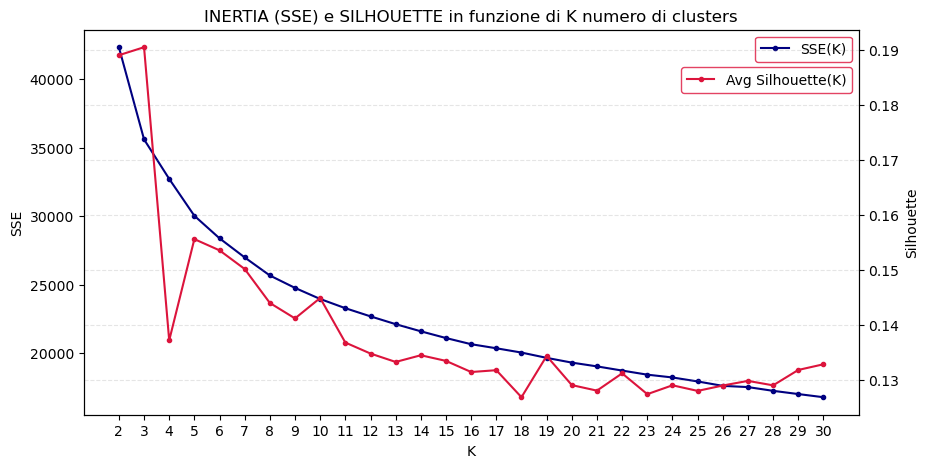

In [14]:
fig, ax = plt.subplots(figsize = (10, 5))

# INERTIA --> SSE
ax.plot(range(2, max_k + 1), sse_list, marker = '.', c = 'navy', label = 'SSE(K)')
ax.set_xlabel('K')
ax.set_ylabel('SSE')
plt.xticks(range(2, max_k + 1))

# SILHOUETTE
axt = ax.twinx()
axt.plot(range(2, max_k + 1), sil_list, marker='.', c = 'crimson', label = 'Avg Silhouette(K)')
axt.set_ylabel('Silhouette')
plt.xticks(range(2, max_k + 1))
plt.grid(color = 'grey', alpha = 0.2, ls = '--')
plt.title('INERTIA (SSE) e SILHOUETTE in funzione di K numero di clusters')

ax.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10)
axt.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10, bbox_to_anchor=(1, 0.92))
plt.show()

Sembra che il miglior numero di clusters sia tra 5 e 7. Tuttavia si preferisce scegliere 5 in quanto potrebbe essere più semplice interpretare un numero inferiore di cluster e i guadagni relativi di SSE nel passaggio da 5 a 7 sembrano irrisori (meno dell'1%).

In [15]:
kmeans = KMeans(n_clusters = 5, n_init = 10, random_state = 0)
kmeans.fit(X)

KMeans(n_clusters=5, n_init=10, random_state=0)

Adesso cerchiamo di validare il risultato ottenuto visualizzando la silhouette per ciascuna delle osservazioni a seguito della scelta del k, per vedere se questo ha portato ad osservazioni clusterizzate particolarmente male, che quindi verranno evidenziate da un **elevato valore di silhouette**.

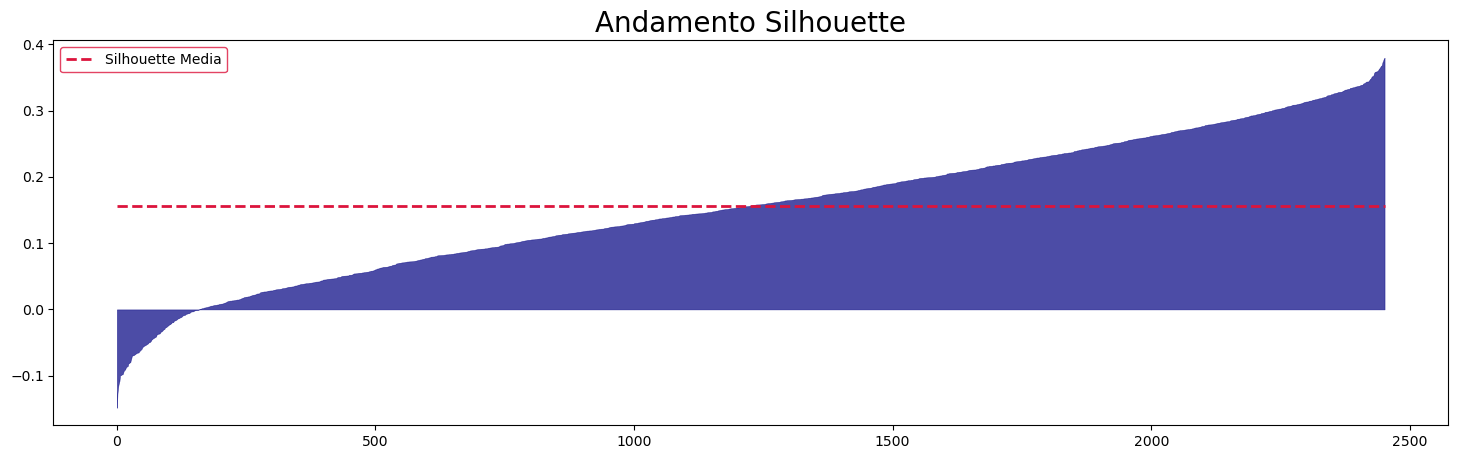

In [16]:
sil_samples = sorted(silhouette_samples(D, kmeans.labels_, metric = 'precomputed'))

fig, ax = plt.subplots(figsize = (18, 5))

ax.fill_between(range(len(sil_samples)), sil_samples, color = 'navy', alpha = 0.7, lw = 0.4)
ax.plot([0, len(sil_samples)], np.mean(sil_samples)*np.ones(2), color = 'crimson', lw = 2, linestyle = '--', label = 'Silhouette Media')
ax.set_title('Andamento Silhouette', fontsize = 20)
ax.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10, loc = 'upper left')
plt.show()

Il grafico conferma che la **silhouette** è negativa solo per un piccolo campione di osservazioni, inferiore al 10%.

Cerchiamo adesso una conferma della scelta effettuata andando ad analizzare specificamente ogni cluster.
Andiamo quindi a plottare i risultati nello spazio delle **componenti principali**:

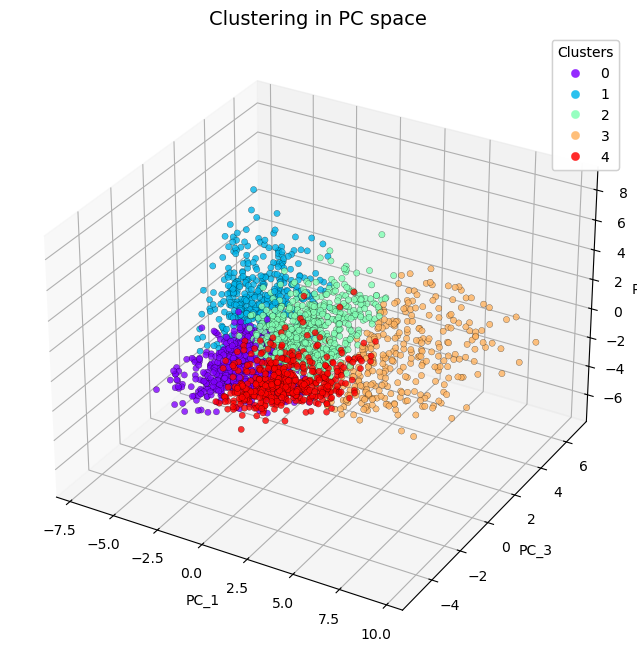

In [17]:
x = 0
y = 1
z = 2 

fig = plt.figure(figsize = (30, 8))
ax = fig.add_subplot(projection = '3d') 
scatter = ax.scatter(X_pca[:, x], X_pca[:, y], X_pca[:, z], c = kmeans.labels_, cmap='rainbow', 
                     s = 20, alpha = 0.8, edgecolor = 'black', linewidth = 0.2, marker = 'o')

ax.set_xlabel(f'PC_{x + 1}')
ax.set_ylabel(f'PC_{y + 2}')
ax.set_zlabel(f'PC_{z + 3}')
ax.set_title(f'Clustering in PC space', fontsize = 14)

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters", loc = 'best')
ax.add_artist(legend1)

plt.show()

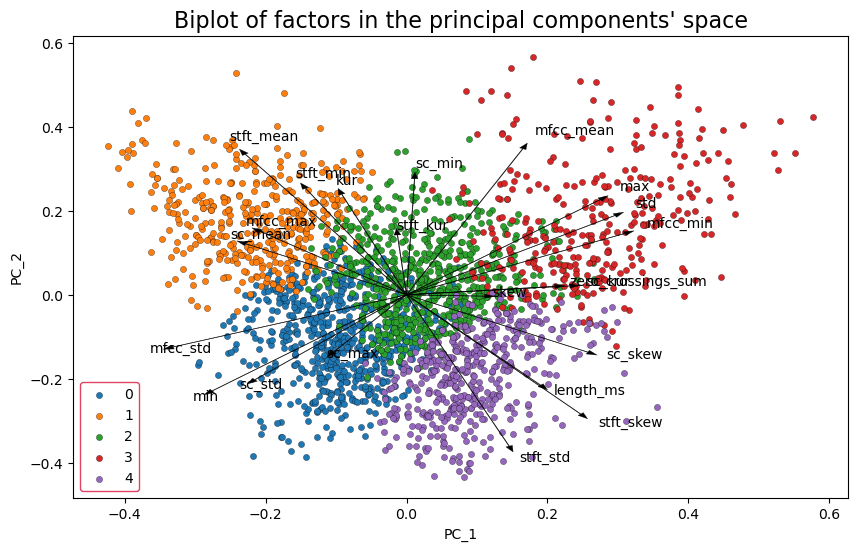

In [18]:
biplot(PC = X_pca,
        # with the transposition the eigenvectors V are on columns
        principal_directions = prin_dir.T,
        list_variable_names = numeric_cols,
        by_class_values = kmeans.labels_,
        idx_1 = 0, idx_2 = 1)

Di seguito alcune considerazioni preliminari:
- Le emozioni caratterizzate da una **forte intensità vocale**, come **angry**, **happy** e **fearful**, sono le sole a toccare elevati valori di PC_1, quindi avranno una maggiore incidenza nei clusters 2, 3 e 4
- Al contrario le emozioni dove l'**intensità vocale è bassa**, come **sad**, **neutral** e **calm** si troveranno maggiormene nei cluster 0, 1 e 2
- I cluster 0, 3 e 4 sono maggiormente rappresentati da donne, mentre 1, 2 da uomini.

Cerchiamo adesso riscontro dell'intuizione grafica andando ad analizzare le statistiche per ogni cluster.
Per prima cosa visualizziamo una tabella riassuntiva incrociando le variabili numeriche analizzate con i cluster ottenuti:

In [19]:
df_cluster['KM_clusters'] = kmeans.labels_
df_cluster.head()

length_ms  zero_crossings_sum  mfcc_mean    mfcc_std   mfcc_min   mfcc_max  \
0     3737.0             16995.0 -33.485947  134.654860 -755.22345  171.69092   
1     3904.0             13906.0 -29.502108  130.485630 -713.98560  205.00770   
2     4671.0             18723.0 -30.532463  126.577110 -726.06036  165.45653   
3     3637.0             11617.0 -36.059555  159.725160 -842.94635  190.03609   
4     4404.0             15137.0 -31.405996  122.125824 -700.70276  161.13400   

       sc_mean       sc_std  sc_min        sc_max    sc_kur   sc_skew  \
0  5792.550744  3328.055457     0.0  13541.959028 -1.120769  0.250940   
1  5197.620555  4040.931570     0.0  12000.290443 -1.531204  0.219582   
2  4830.743037  3332.131300     0.0  12007.751173 -1.130153  0.436699   
3  5376.446478  4053.663073     0.0  12048.223893 -1.497765  0.098802   
4  5146.012474  3442.724109     0.0  12025.582707 -1.167544  0.496066   

   stft_mean  stft_std  stft_min  stft_kur  stft_skew       std       min  \
0   0.415250  0.335533       0.0 -1.215025   0.403514  0.014482 -0.128632   
1   0.417488  0.352380       0.0 -1.384174   0.290905  0.020417 -0.305725   
2   0.379758  0.352270       0.0 -1.242947   0.470350  0.024317 -0.137482   
3   0.407277  0.360552       0.0 -1.445318   0.274756  0.003561 -0.027374   
4   0.415974  0.350655       0.0 -1.366742   0.318926  0.027522 -0.192169   

        max        kur      skew  sex    emotion  KM_clusters  
0  0.138947   9.406061  0.273153  0.0    fearful            4  
1  0.263062  19.564187  0.292157  0.0      angry            0  
2  0.166351   4.881241  0.302659  0.0      happy            4  
3  0.024078  13.040259 -0.081014  0.0  surprised            0  
4  0.242676   7.485109  0.414872  0.0      happy            4

Di seguito **l'andamento di media e deviazione standard** per i **diversi attributi continui** al variare del cluster.

In [20]:
cluster_means = df_cluster.drop(columns = ['sex', 'emotion']).groupby('KM_clusters').mean().T
cluster_means.columns = [str(j) + '_mu' for j in cluster_means.columns]

cluster_std = df_cluster.drop(columns = ['sex', 'emotion']).groupby('KM_clusters').std().T
cluster_std.columns = [str(j) + '_std' for j in cluster_std.columns]

cluster_stats = pd.merge(cluster_means, cluster_std, left_index = True, right_index = True)
cluster_stats = cluster_stats[sorted(cluster_stats.columns)]

cluster_stats

0_mu        0_std          1_mu        1_std  \
length_ms            3823.632558   403.142785   3552.037406   322.223371   
zero_crossings_sum  11724.232558  3093.508657  10445.845387  2433.834678   
mfcc_mean             -32.104590     3.191596    -28.601587     2.666362   
mfcc_std              149.114706    14.490241    157.729974    13.814607   
mfcc_min             -814.149578    76.856519   -849.491221    77.462645   
mfcc_max              204.265113    18.549848    224.435588    19.341438   
sc_mean              5580.158869   700.016775   6048.012886   670.852732   
sc_std               3856.760836   346.410730   3551.368717   464.543624   
sc_min                241.006708   444.487305    840.704042   379.911237   
sc_max              12323.065099   845.244596  11969.151251   848.092994   
sc_kur                 -1.422035     0.219885     -1.474855     0.182696   
sc_skew                 0.202336     0.225212     -0.043976     0.222581   
stft_mean               0.473078     0.053085      0.596700     0.037672   
stft_std                0.341540     0.016118      0.295201     0.017651   
stft_min                0.000324     0.000886      0.009113     0.008396   
stft_kur               -1.370606     0.099318     -1.046928     0.215536   
stft_skew               0.067188     0.198436     -0.344787     0.197225   
std                     0.009495     0.006542      0.006781     0.005289   
min                    -0.079262     0.058793     -0.066038     0.056030   
max                     0.085925     0.067282      0.072187     0.060931   
kur                    11.724938     5.986940     16.593395     8.752359   
skew                   -0.021743     0.426531     -0.208001     0.640954   

                            2_mu        2_std          3_mu        3_std  \
length_ms            4214.521463   513.086872   4188.455414   492.546464   
zero_crossings_sum  12625.674086  2925.369685  16347.398089  4172.490572   
mfcc_mean             -25.557483     2.277526    -23.387920     3.072005   
mfcc_std              130.781464    10.684172    103.648295     7.445623   
mfcc_min             -736.018061    55.629831   -597.626464    41.320402   
mfcc_max              206.838019    18.157928    178.618373    21.229211   
sc_mean              4747.337609   662.474962   4842.284922   844.518948   
sc_std               3029.185491   479.065910   2809.764224   617.435559   
sc_min                824.356848   318.413616    712.523691   569.324816   
sc_max              11322.278057   965.564887  11387.807714  1176.919349   
sc_kur                 -1.066218     0.495942     -0.601164     0.871491   
sc_skew                 0.458627     0.286313      0.576265     0.370450   
stft_mean               0.489451     0.043722      0.451344     0.063985   
stft_std                0.328695     0.015182      0.332275     0.018110   
stft_min                0.002140     0.002301      0.001100     0.001931   
stft_kur               -1.317924     0.124583     -1.213191     0.221114   
stft_skew               0.102138     0.196305      0.239141     0.284183   
std                     0.019475     0.008974      0.064473     0.024013   
min                    -0.154489     0.080401     -0.539403     0.193506   
max                     0.162944     0.088878      0.599322     0.211464   
kur                     9.634628     4.888467     12.562091     5.763623   
skew                   -0.174690     0.413566      0.221783     0.269413   

                            4_mu        4_std  
length_ms            4702.453564   553.817579  
zero_crossings_sum  14620.397408  3327.853235  
mfcc_mean             -32.280496     3.190946  
mfcc_std              132.056082    12.553745  
mfcc_min             -743.981157    64.835990  
mfcc_max              173.776612    20.644636  
sc_mean              4635.162352   635.747617  
sc_std               3353.690031   363.735647  
sc_min                255.448655   444.337774  
sc_max              12014.689699   811.979046  
sc

Di seguito il supporto, ovvero il numero di osservazioni che risiedono in ogni cluster, al variare di **sesso** ed **emotion**.

Ricordare che:
- Sex = 0 --> Female
- Sex = 1 --> Male

In [21]:
cluster_count = pd.crosstab(index = df_cluster['sex'], 
                            columns = df_cluster['KM_clusters'],
                            values = df_cluster['mfcc_mean'],
                            aggfunc = 'count').fillna(0)

cluster_count

KM_clusters    0    1    2    3    4
sex                                 
0.0          450   26  128  179  421
1.0          195  375  501  135   42

In [22]:
cluster_count = pd.crosstab(index = df_cluster['emotion'], 
                            columns = df_cluster['KM_clusters'],
                            values = df_cluster['mfcc_mean'],
                            aggfunc = 'count').fillna(0)

cluster_count

KM_clusters      0     1      2      3      4
emotion                                      
angry         49.0  25.0   90.0  173.0   39.0
calm         116.0  84.0   67.0    1.0  108.0
disgust       75.0  58.0   40.0    5.0   14.0
fearful       57.0  36.0  128.0   80.0   75.0
happy         77.0  38.0  129.0   46.0   86.0
neutral       66.0  48.0   31.0    0.0   43.0
sad          111.0  60.0  105.0    6.0   94.0
surprised     94.0  52.0   39.0    3.0    4.0

Questa tabella permette di confermare le supposizioni grafiche viste in precedenza:

- Le **donne (Sex = 0)** prevalgono nei **cluster 0, 3 e 4**

- Gli **uomini (Sex = 1)** prevalgono nei **cluster 1 e 2**

- Il **cluster 3** è il più bilanciato sull'attributo Sex

- Le emozioni caratterizzate da una forte intensità vocale, come **angry**, **fearful** ed **happy** prevalgono nei **cluster 2, 3**

- Le emozioni **deboli** come **calm**, **neutral**, **sad**, **surprised** prevalgono nei **cluster 0 e 2**

- Il **cluster 1** è molto **bilanciato** in termini di emozioni


In [23]:
cluster_count = pd.crosstab(index = [df_cluster['sex'], df_cluster['emotion']], 
                            columns = df_cluster['KM_clusters'],
                            values = df_cluster['mfcc_mean'],
                            aggfunc = 'count').fillna(0)

cluster_count

KM_clusters       0     1      2     3     4
sex emotion                                 
0.0 angry      39.0   0.0   23.0  84.0  38.0
    calm       77.0  10.0    7.0   1.0  89.0
    disgust    62.0   4.0   12.0   4.0  14.0
    fearful    36.0   1.0   23.0  52.0  72.0
    happy      51.0   2.0   20.0  33.0  78.0
    neutral    42.0   4.0    4.0   0.0  42.0
    sad        71.0   4.0   22.0   3.0  84.0
    surprised  72.0   1.0   17.0   2.0   4.0
1.0 angry      10.0  25.0   67.0  89.0   1.0
    calm       39.0  74.0   60.0   0.0  19.0
    disgust    13.0  54.0   28.0   1.0   0.0
    fearful    21.0  35.0  105.0  28.0   3.0
    happy      26.0  36.0  109.0  13.0   8.0
    neutral    24.0  44.0   27.0   0.0   1.0
    sad        40.0  56.0   83.0   3.0  10.0
    surprised  22.0  51.0   22.0   1.0   0.0

Per semplicità di analisi plottiamo graficamente le **distribuzioni delle variabili** al variare dei **cluster** sfruttando diversi **violinplot**, uno per ogni variabile.

Inoltre aggiungiamo il **violino Overall** relativo alla distribuzione totale di ogni specifica variabile, senza differenziazione sul cluster.

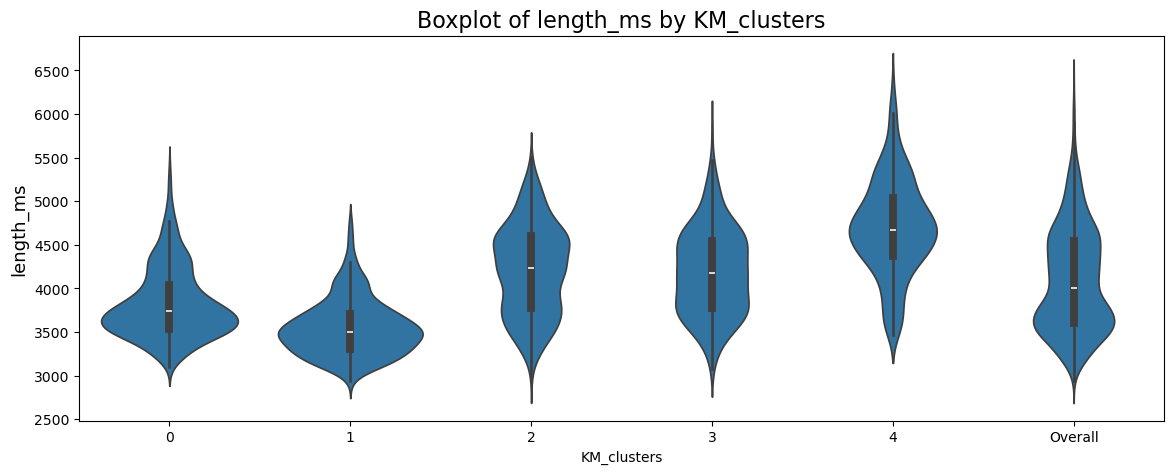

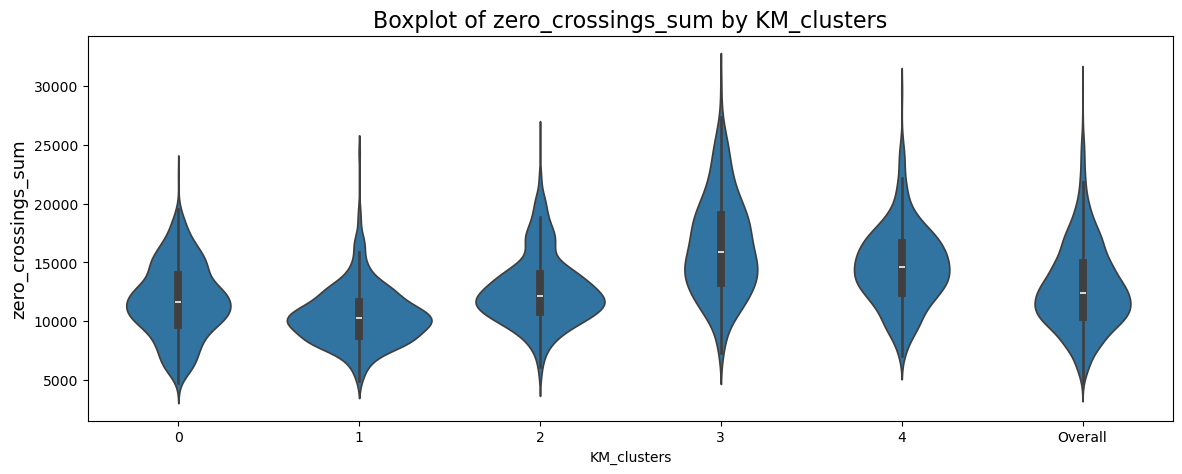

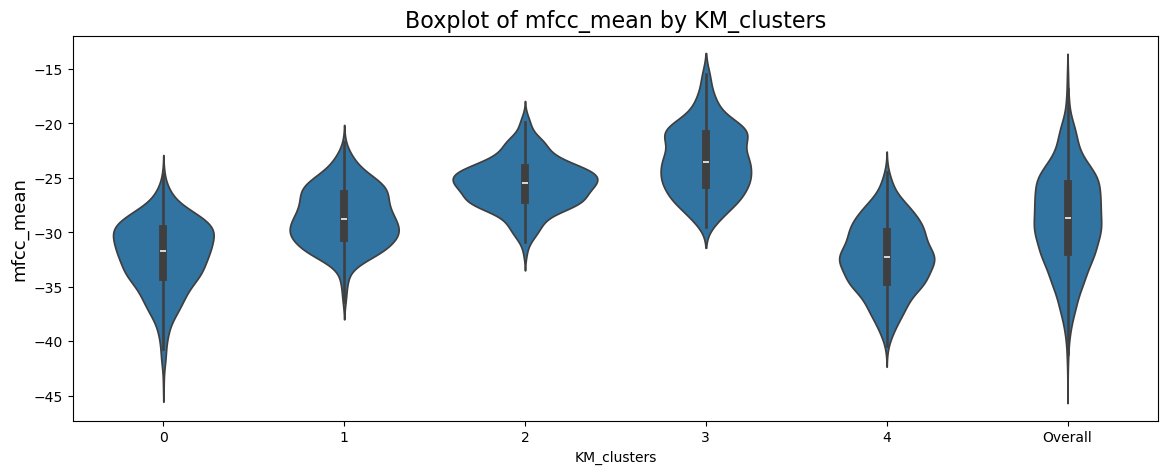

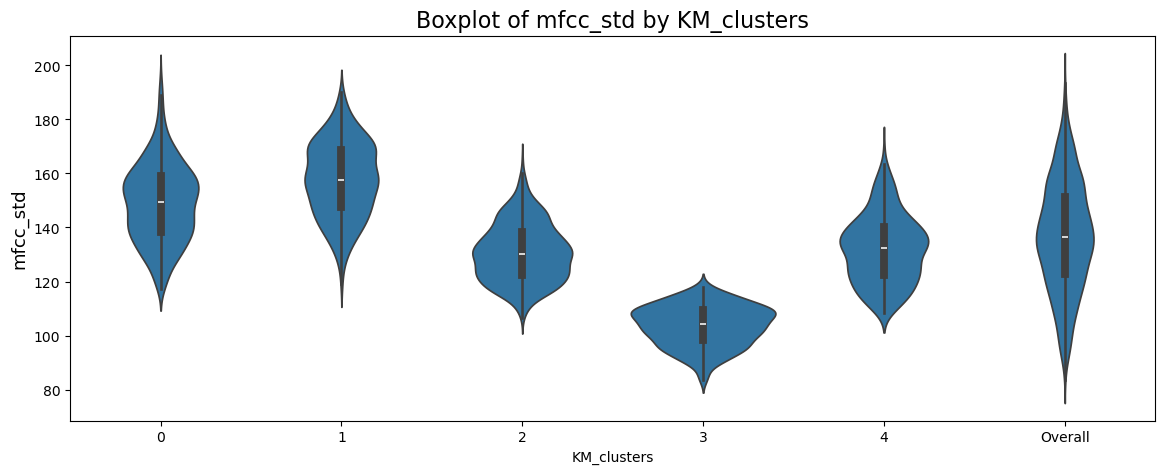

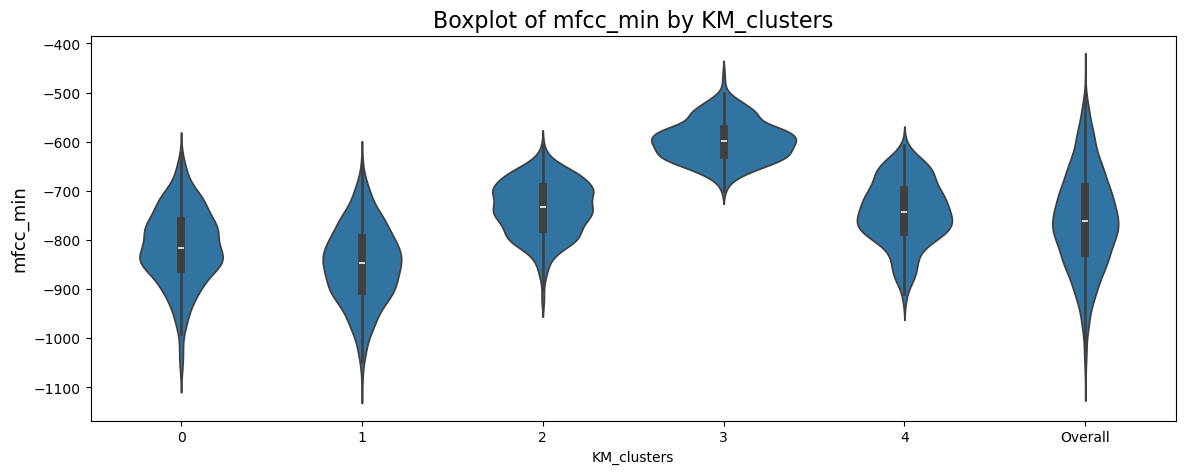

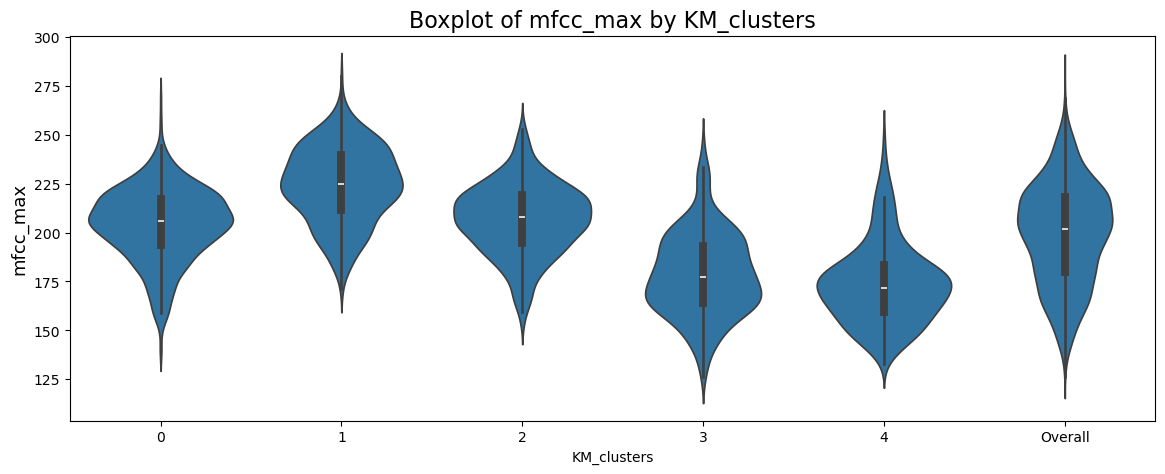

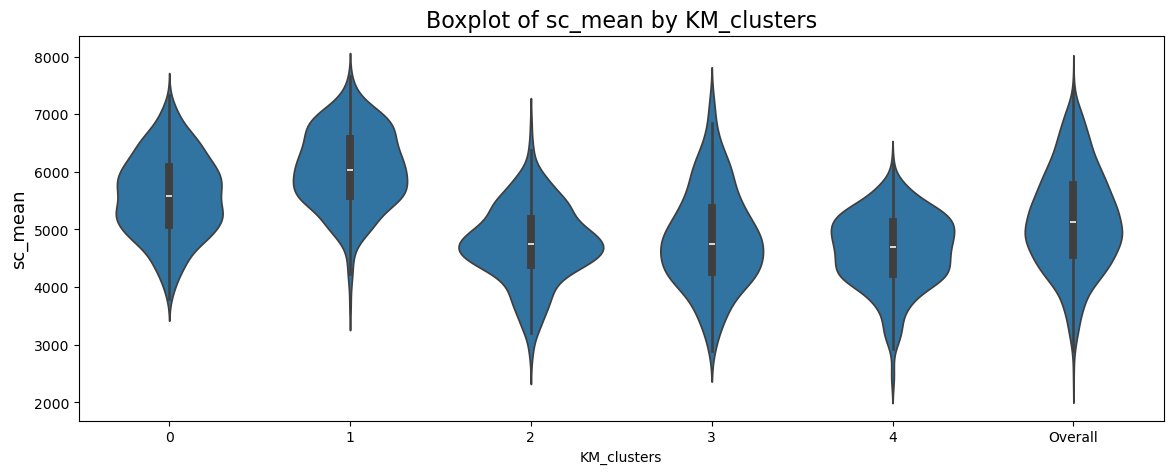

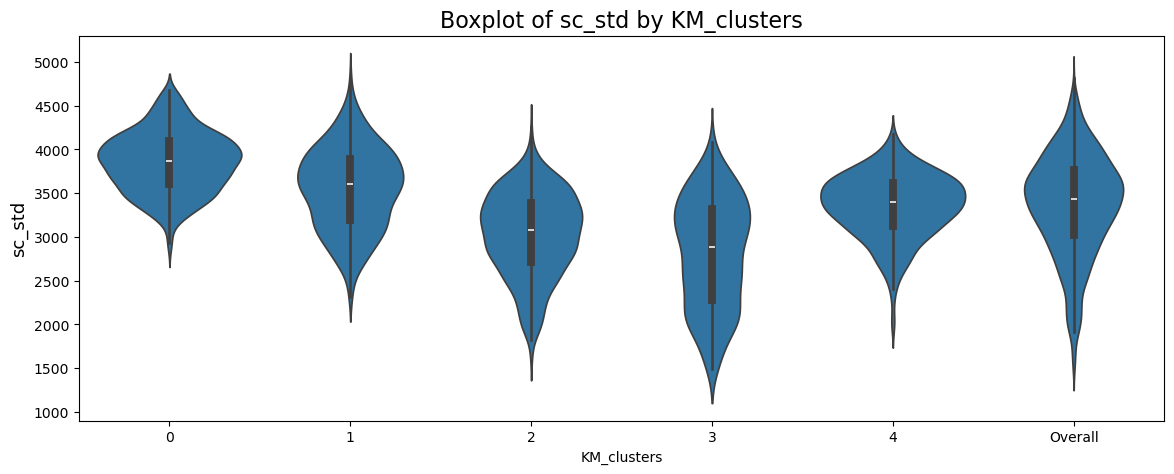

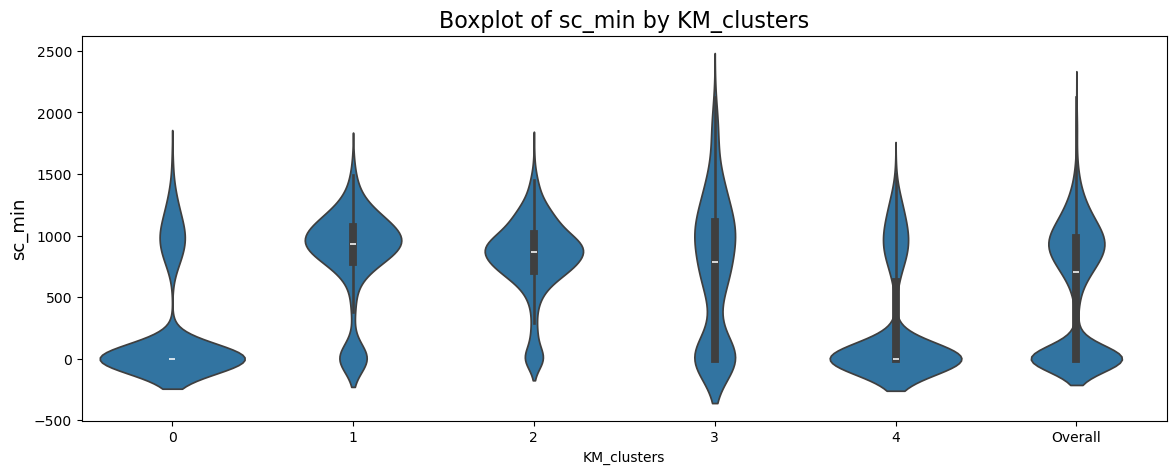

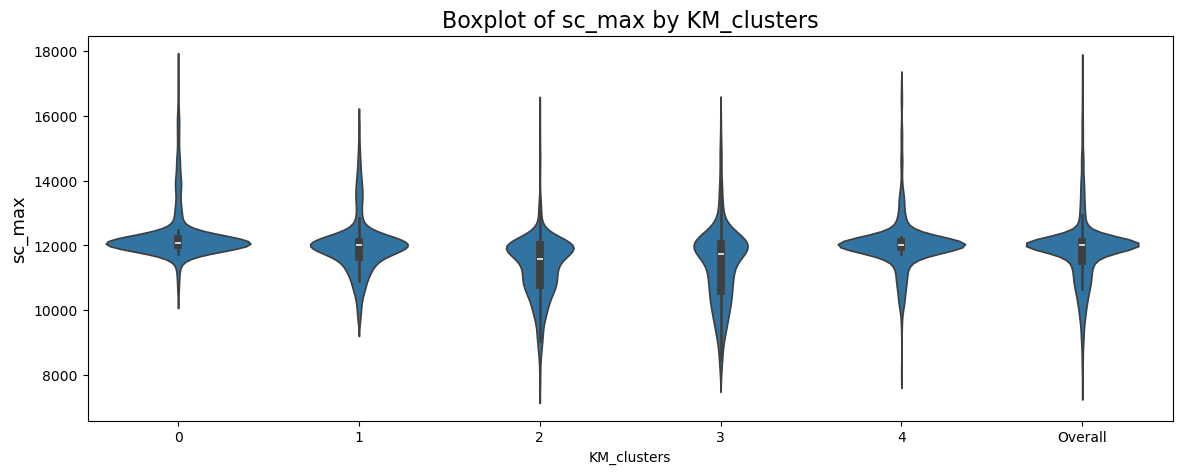

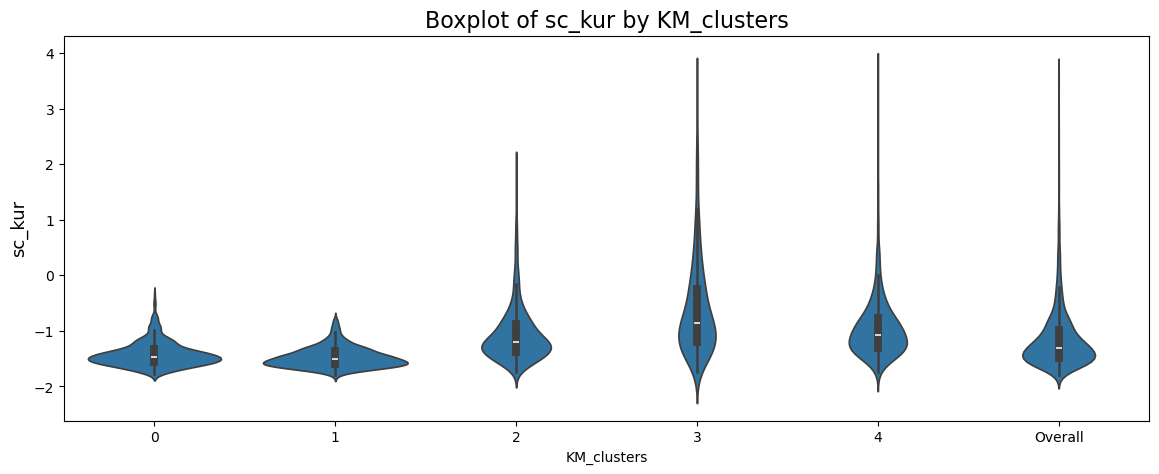

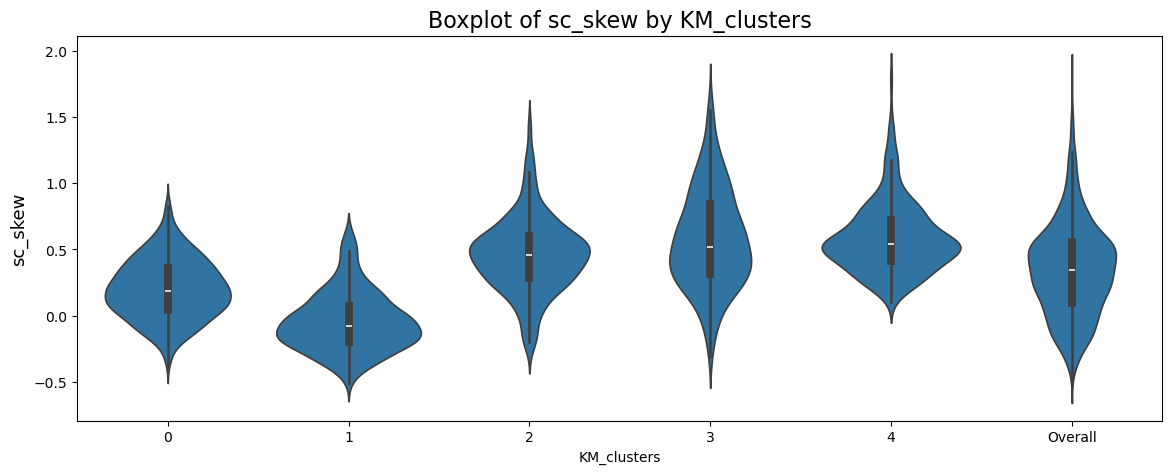

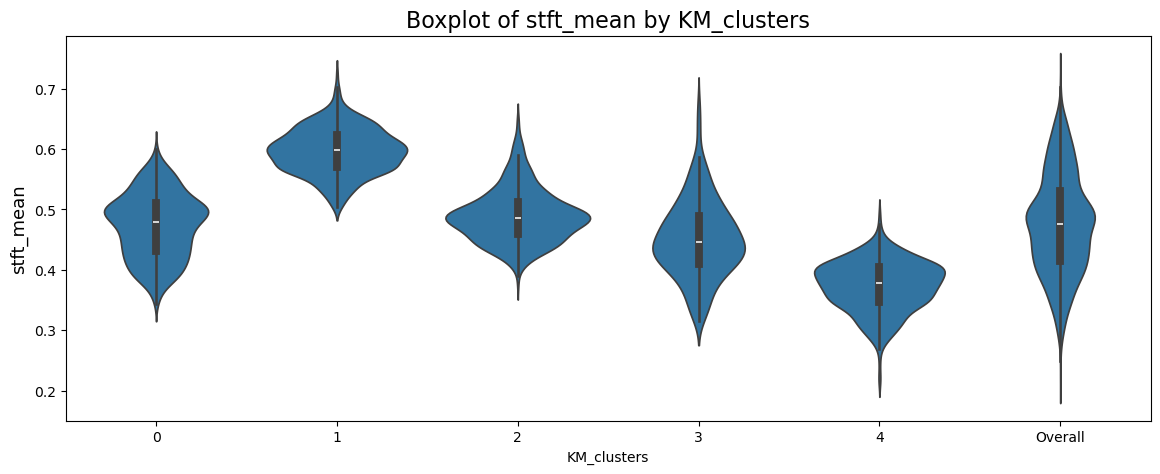

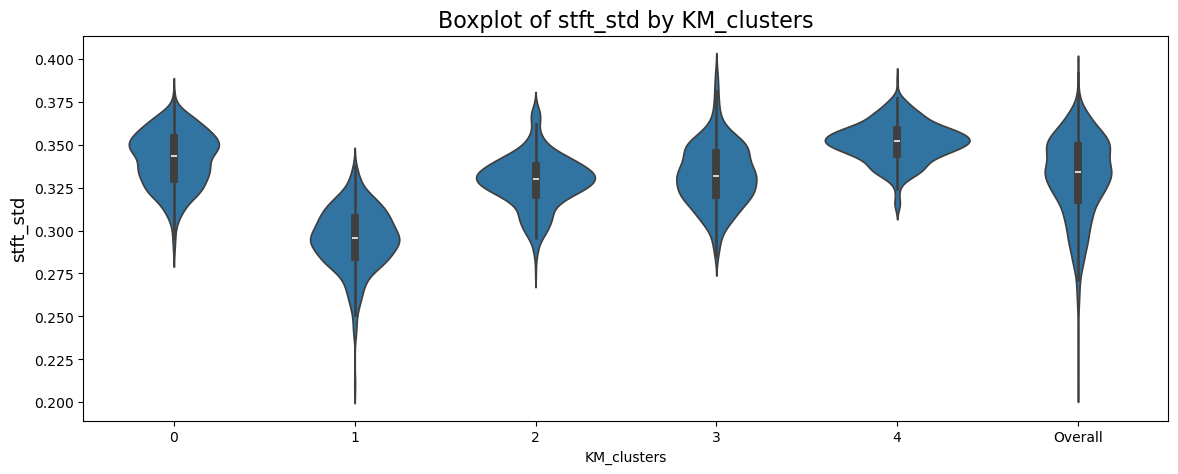

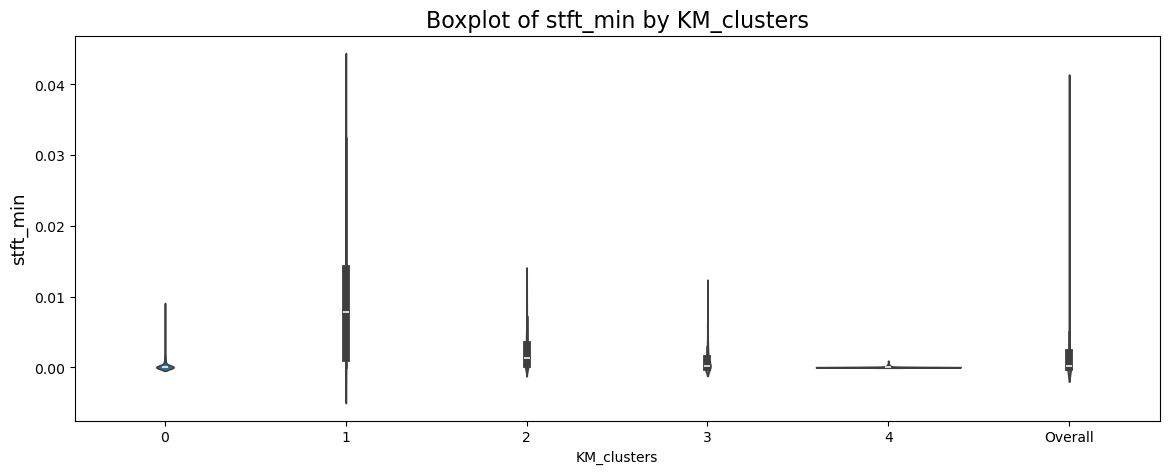

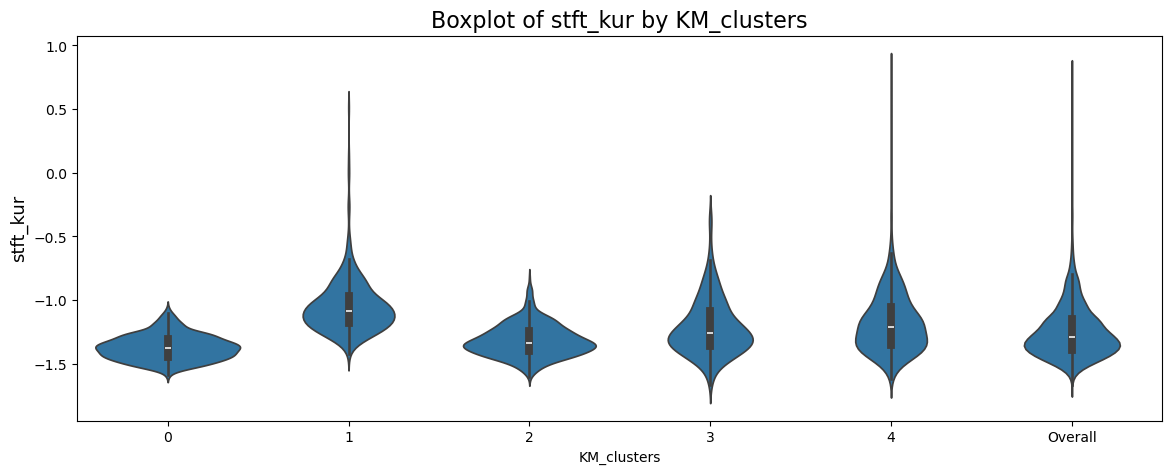

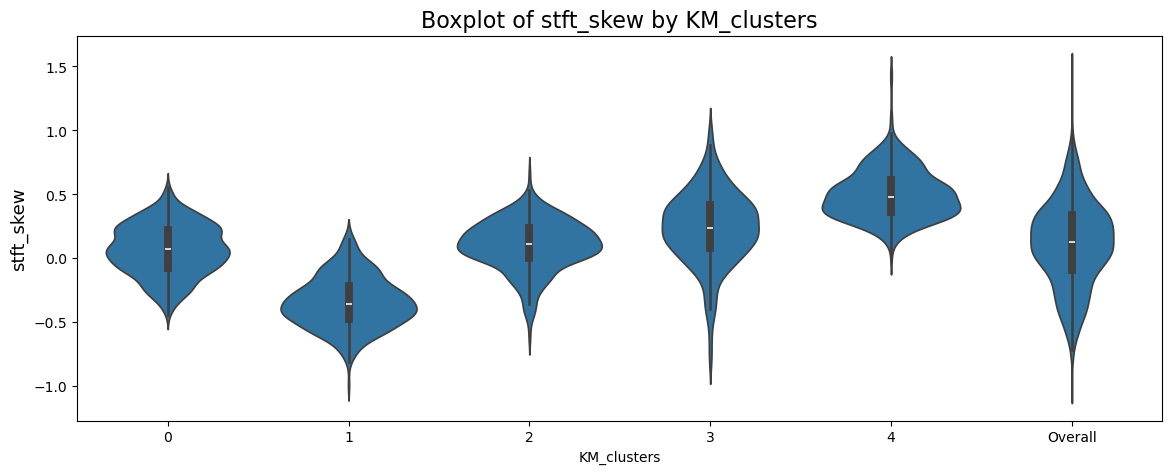

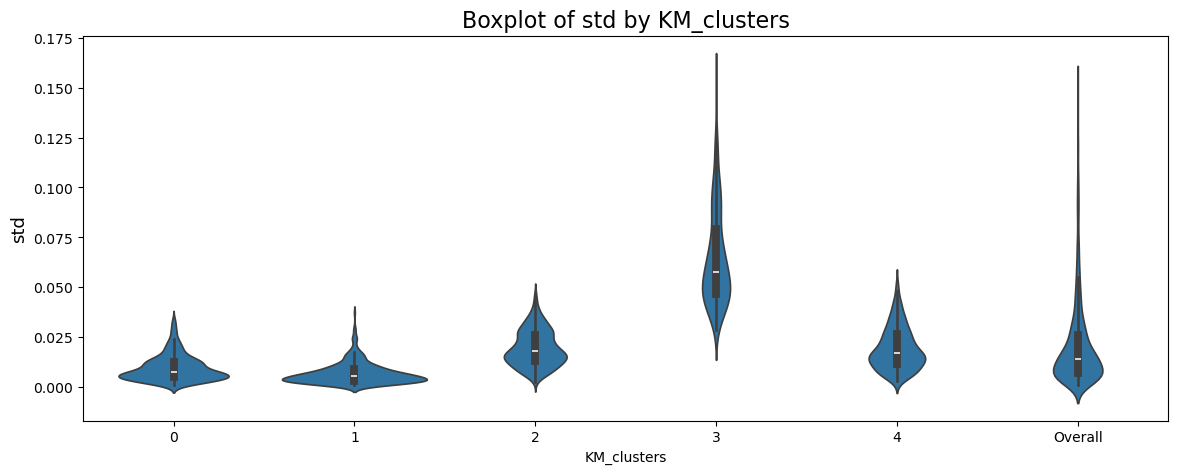

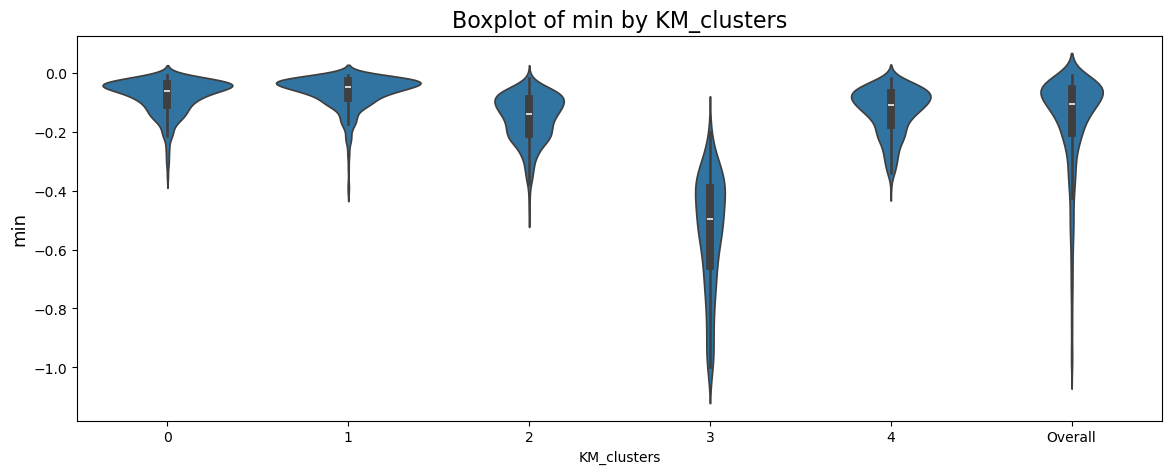

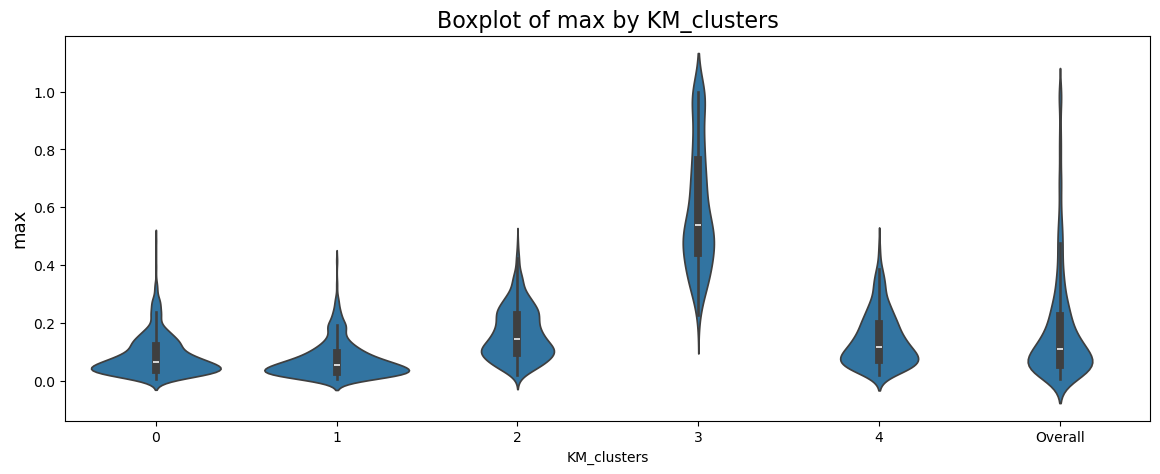

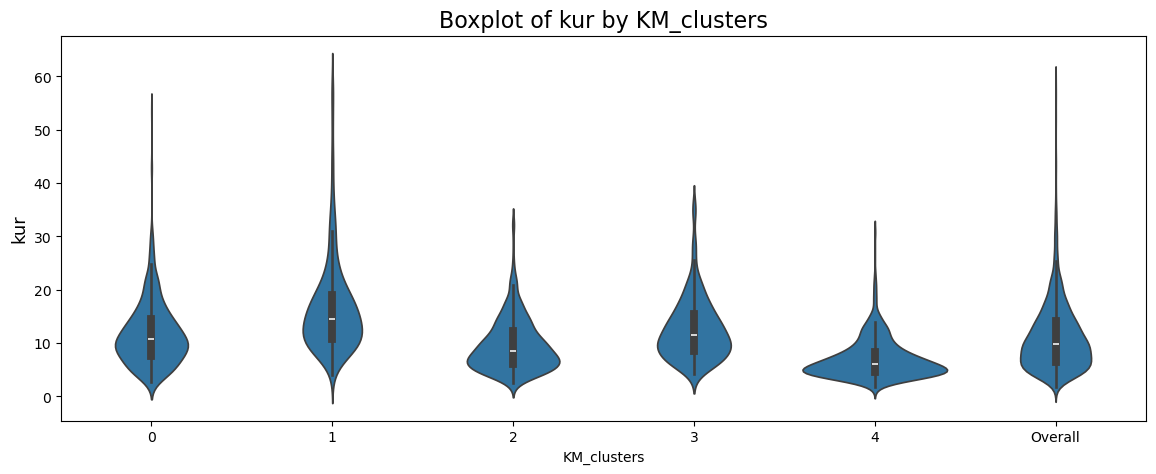

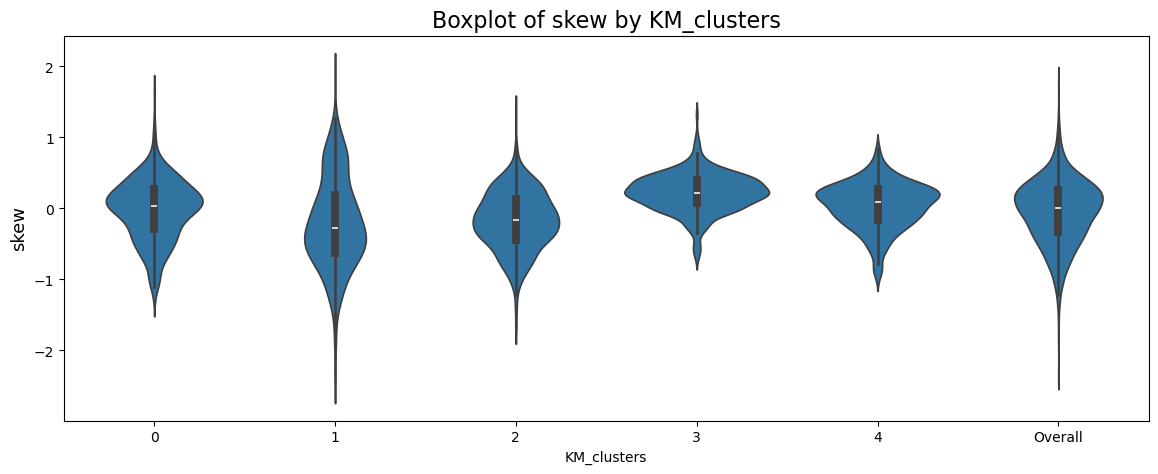

In [24]:
target = 'KM_clusters'

for col in numeric_cols:
    
    fig, ax = plt.subplots(figsize = (14, 5))
    
    df_temp = df_cluster[[col, target]].melt(id_vars = [target])
    df_temp = df_temp.sort_values(by = target)

    # Mi ricreo la distribuzione della variabile non suddivisa sui cluster, ma su tutto il dataset originario
    overall_dist = df[col].copy(deep = True).rename('value').to_frame()
    overall_dist['variable'] = col
    overall_dist[target] = 'Overall'
    overall_dist = overall_dist[[target, 'variable', 'value']]
    df_temp = pd.concat([df_temp, overall_dist], axis = 0).reset_index()
    
    sns.violinplot(x = target, y = 'value', data = df_temp, ax = ax, split = False, inner = 'box')
    ax.set_title(f'Boxplot of {col} by {target}', fontsize = 16)
    ax.set_ylabel(col, fontsize = 13)
    
    plt.show()

Adesso aggiungiamo una dimensione all'analisi appena fatta.

Il proposito dei seguenti grafici è esplorare le **distribuzioni delle variabili originarie** al variare dei cluster, ma mettendo una lente di ingrandimento sul comportamento di:
- **Sex**
- **Emotion**

all'interno dei vari clusters.

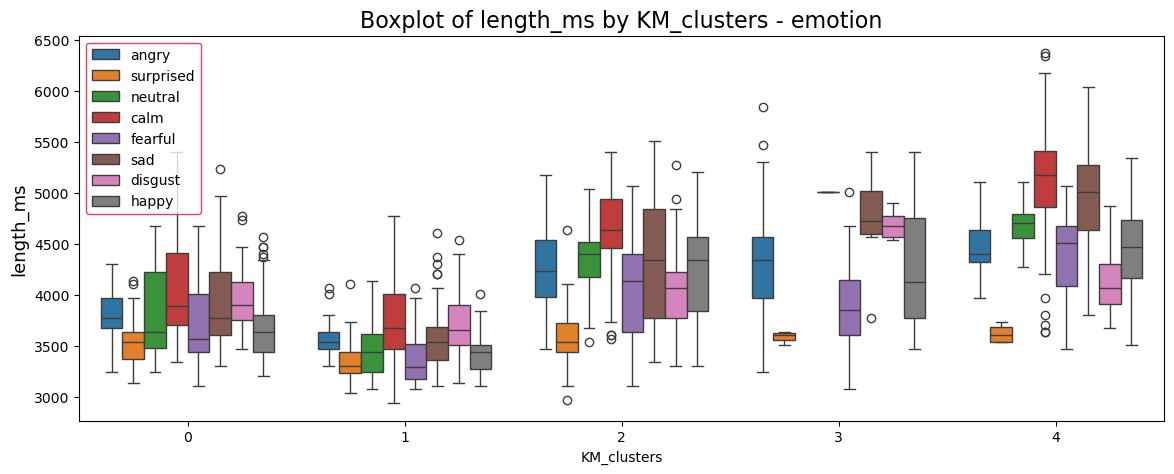

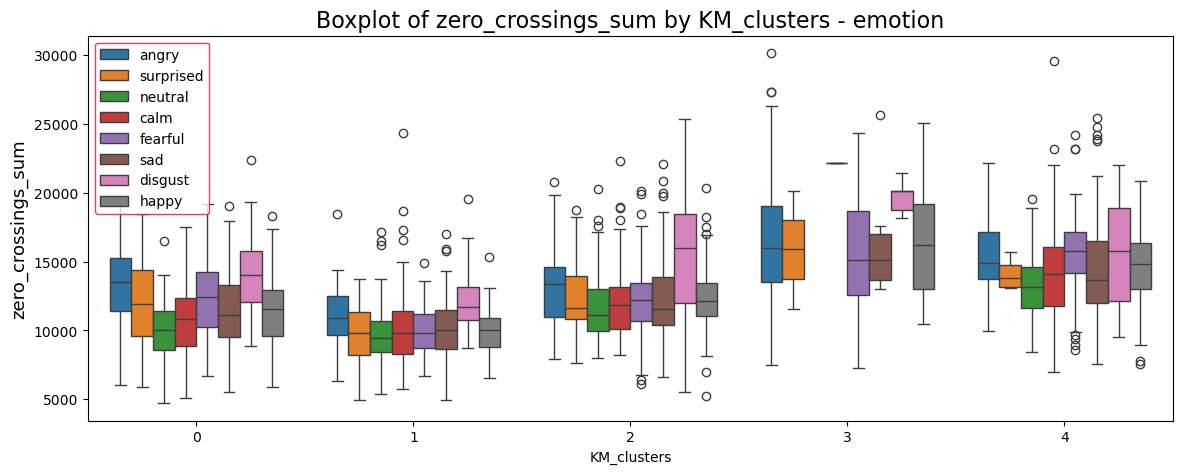

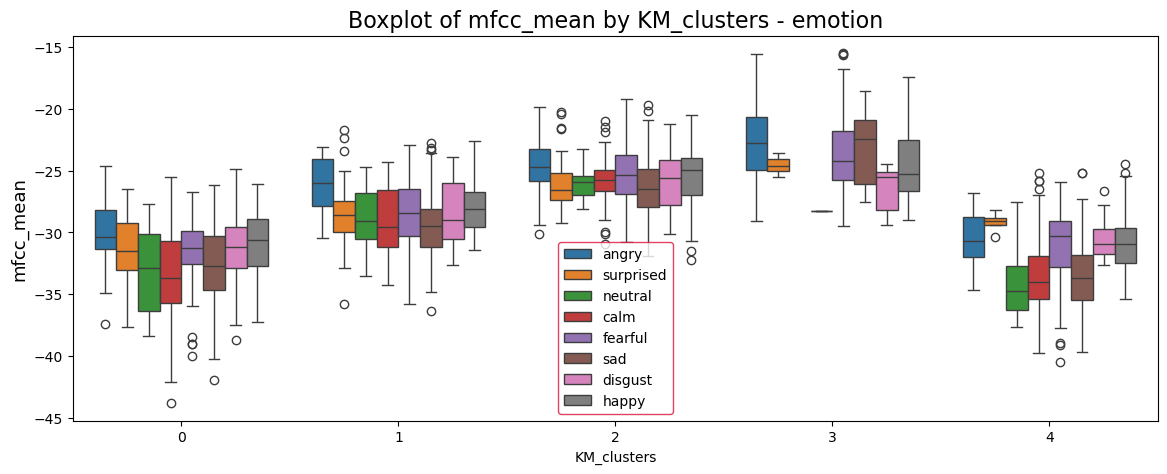

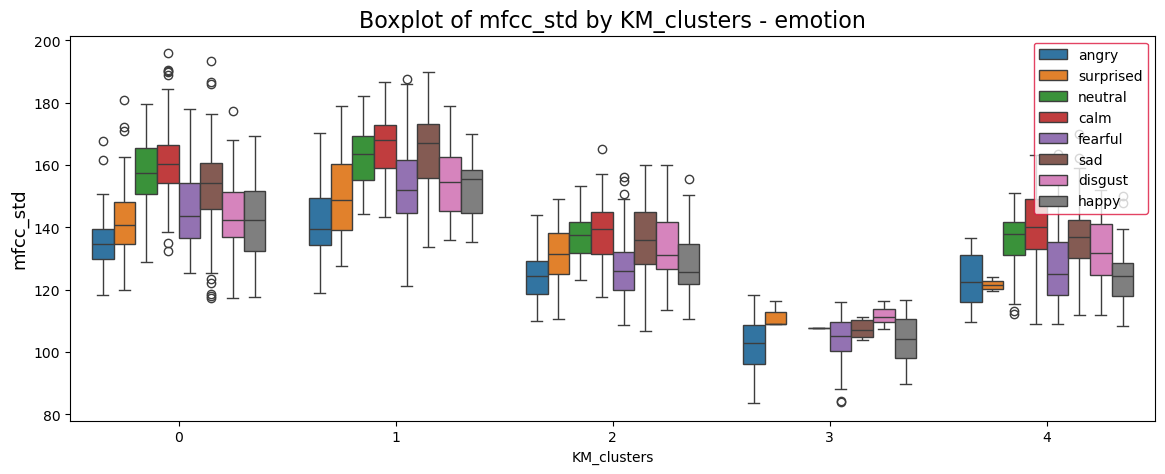

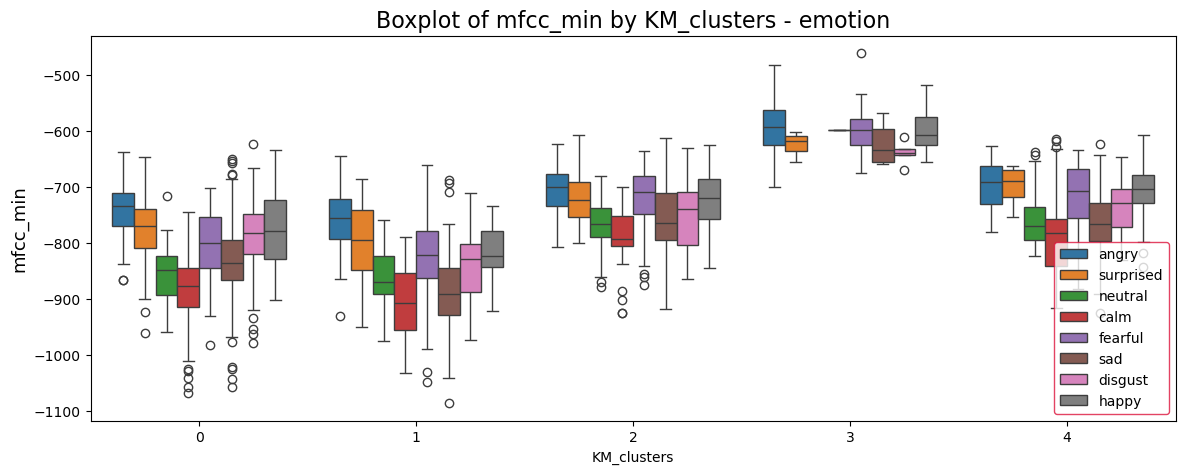

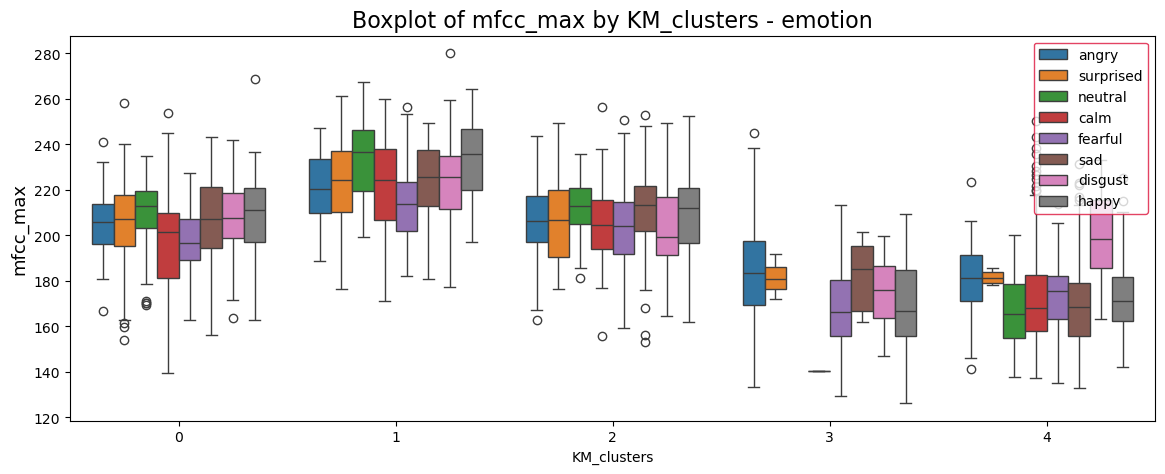

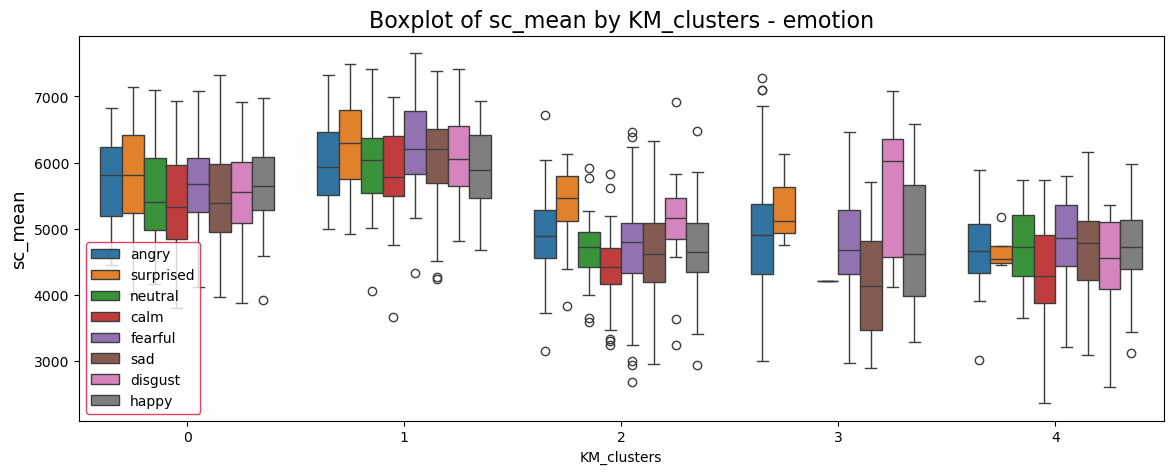

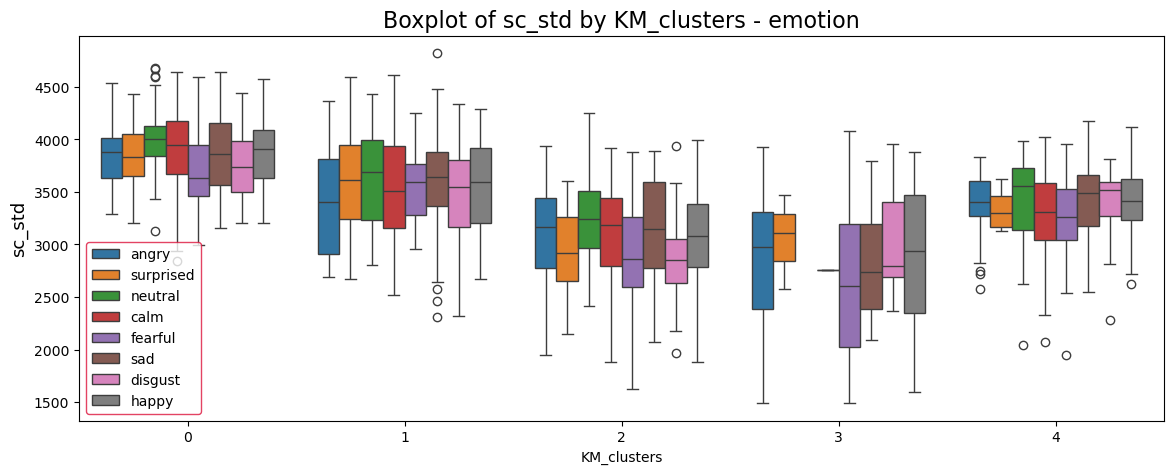

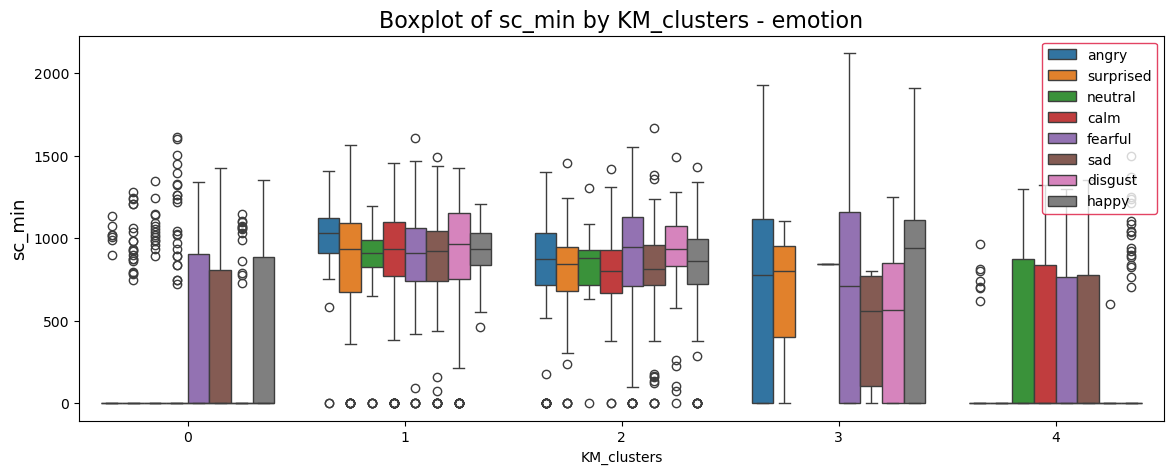

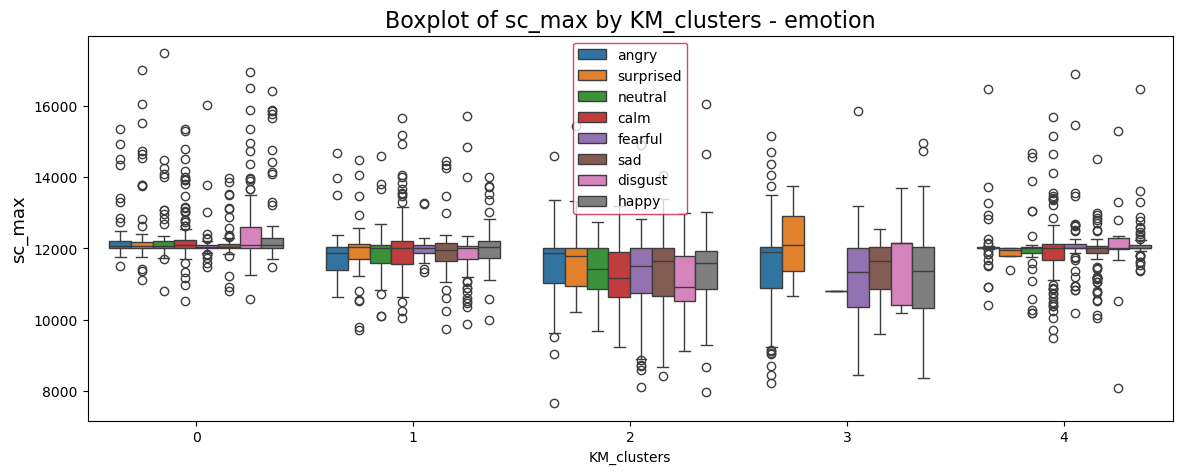

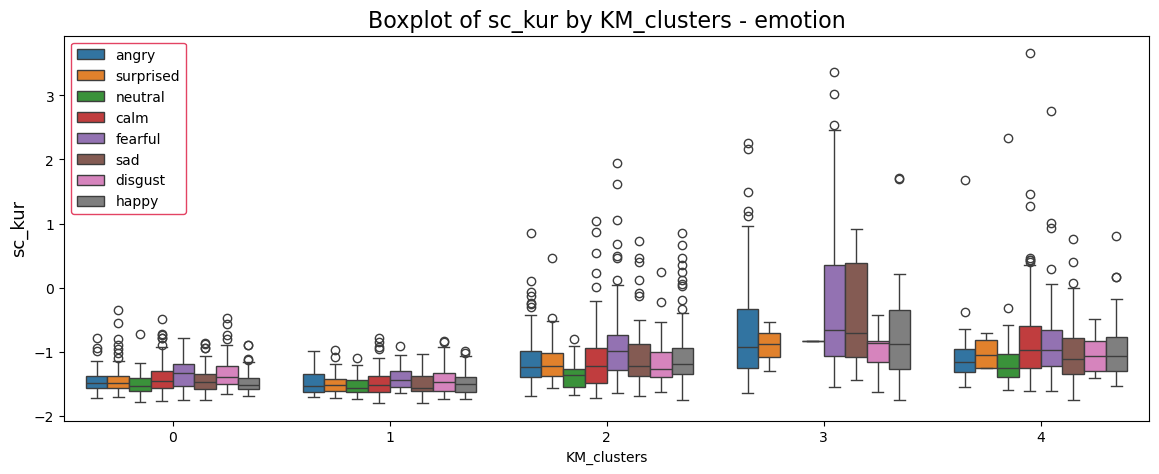

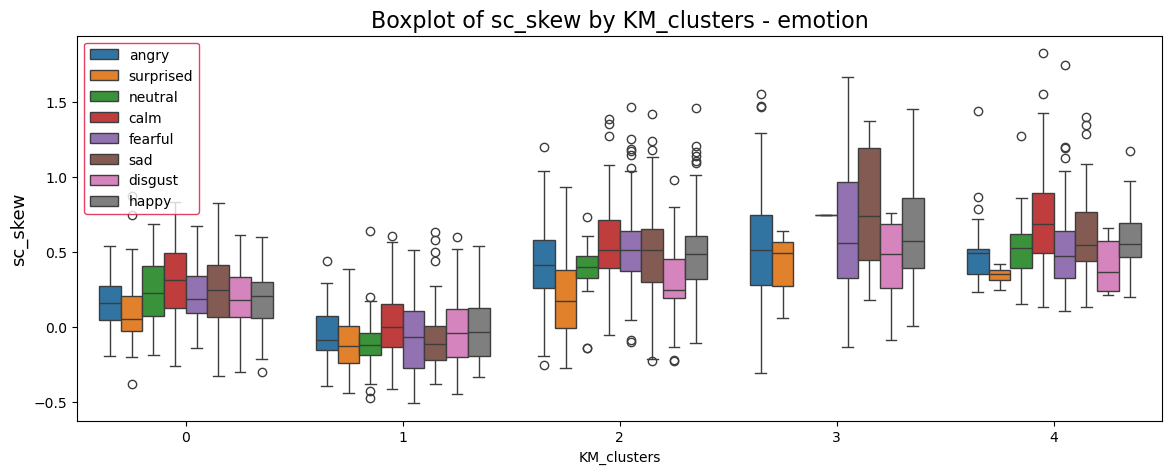

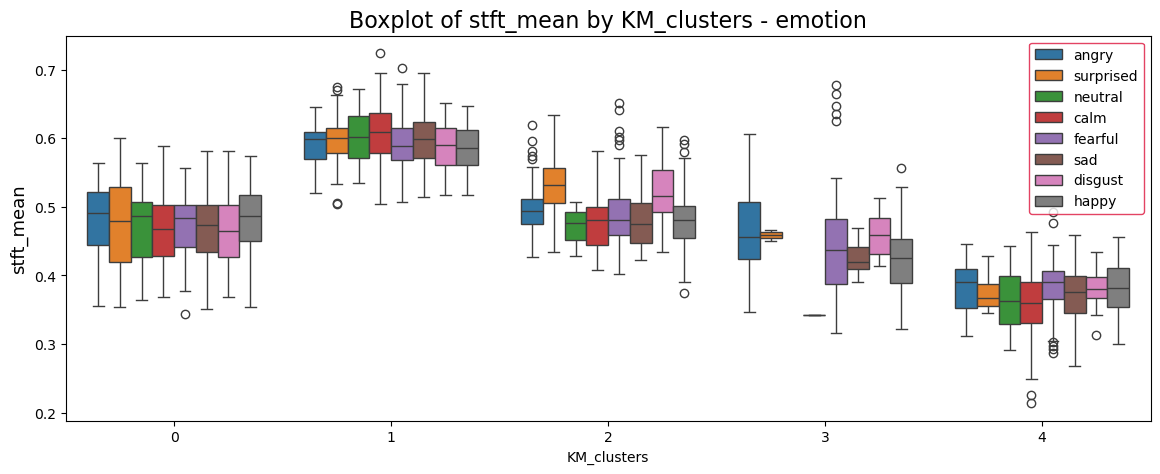

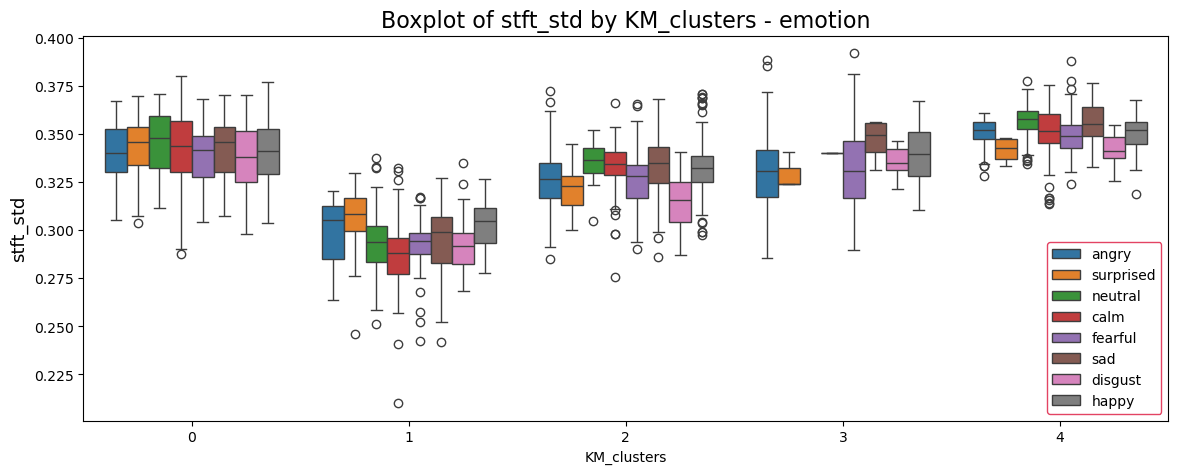

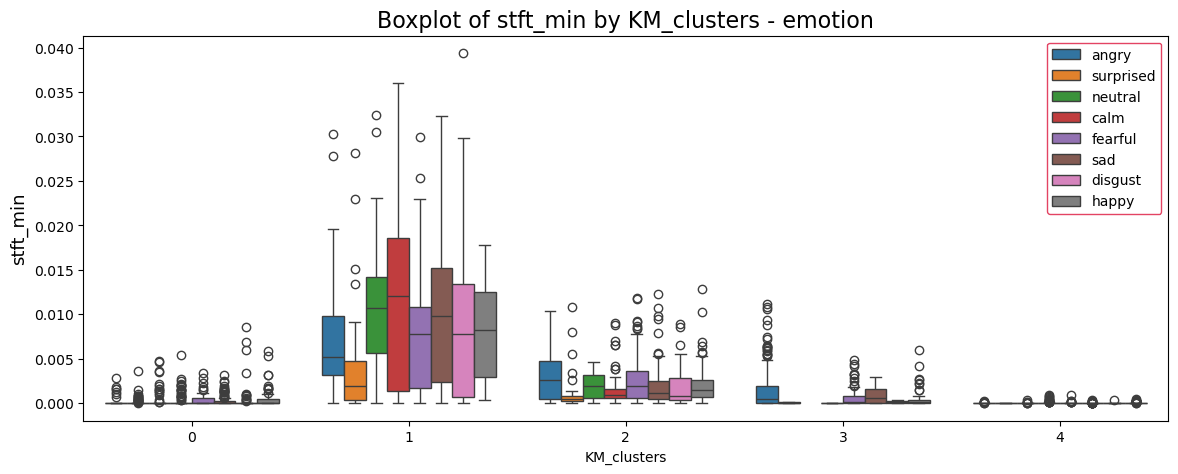

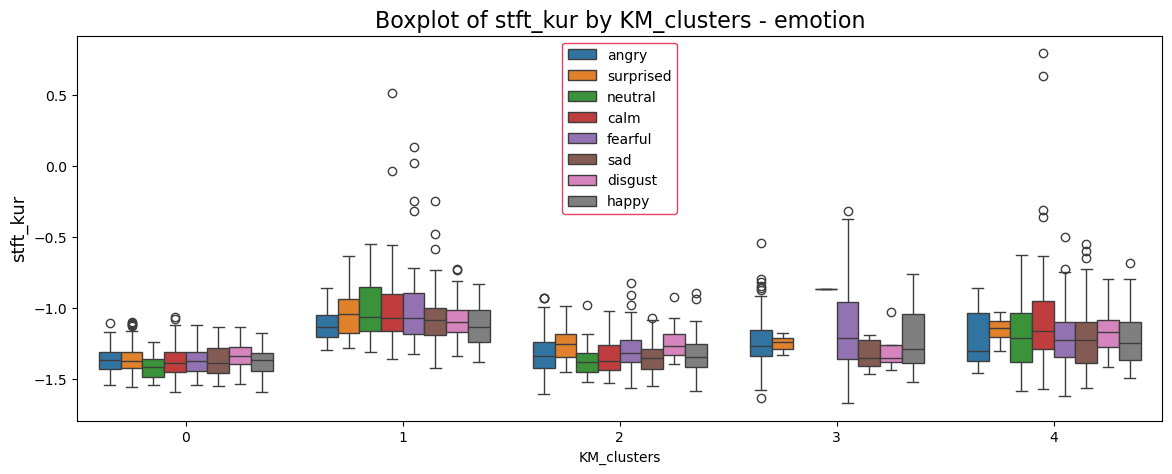

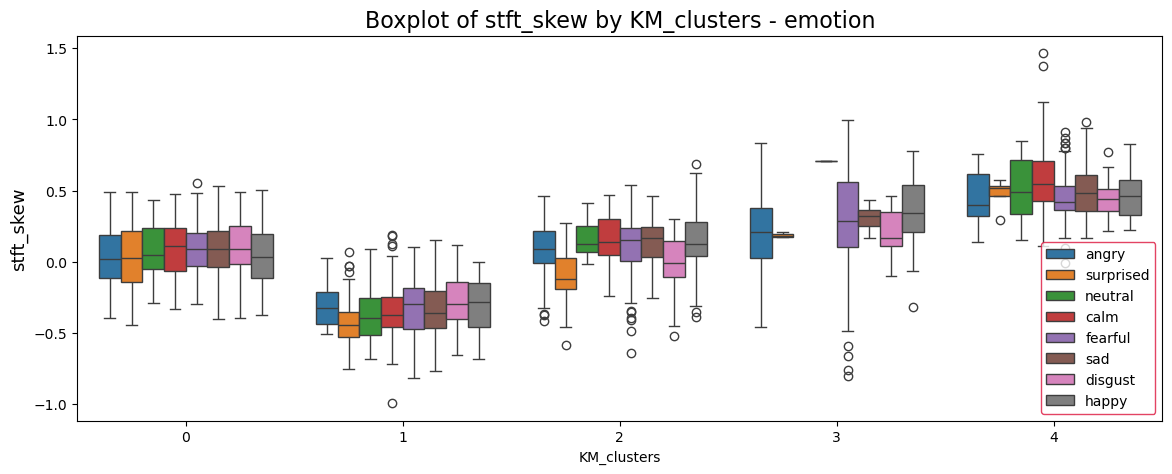

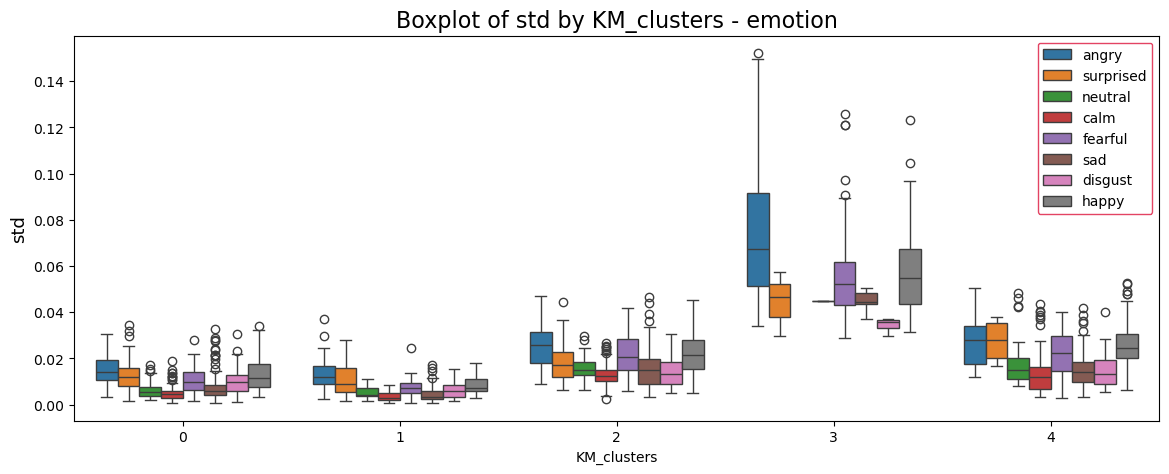

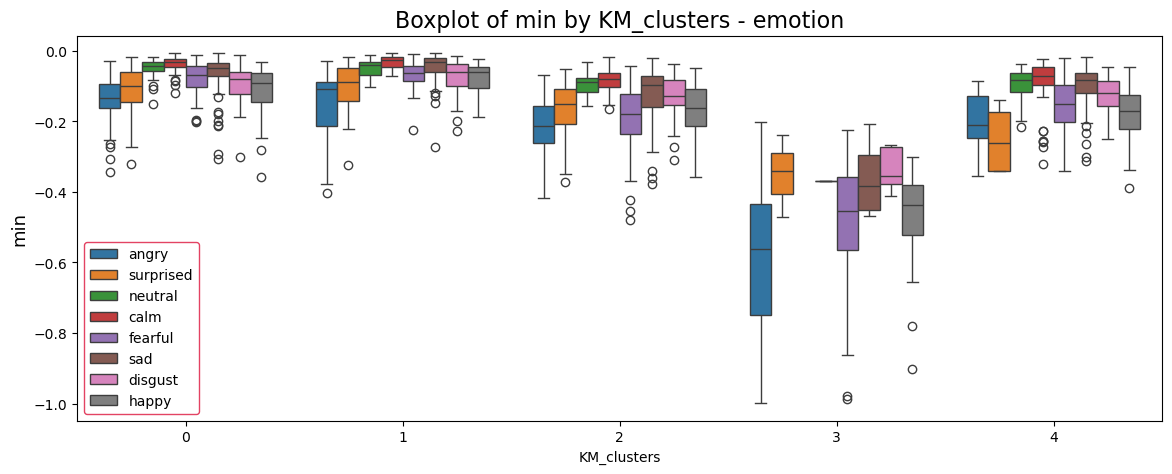

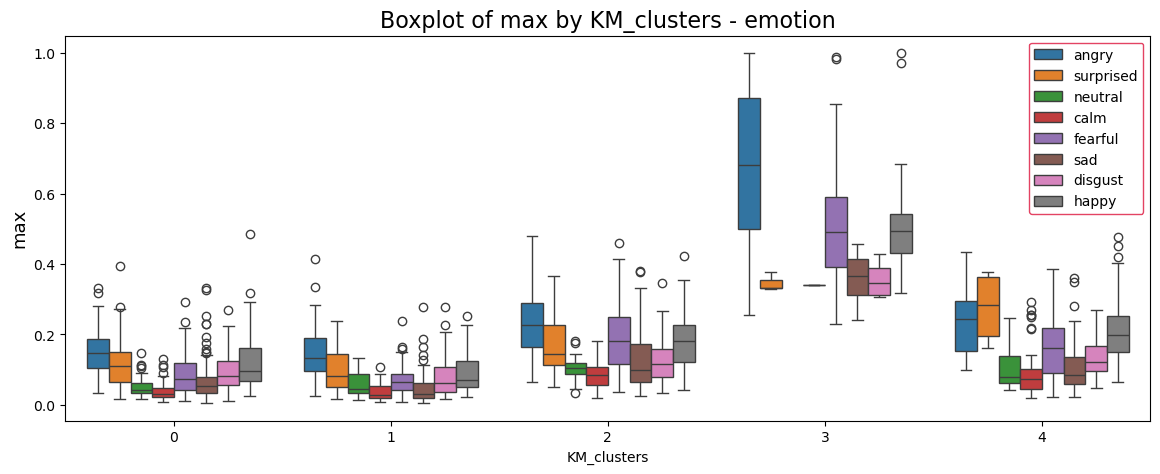

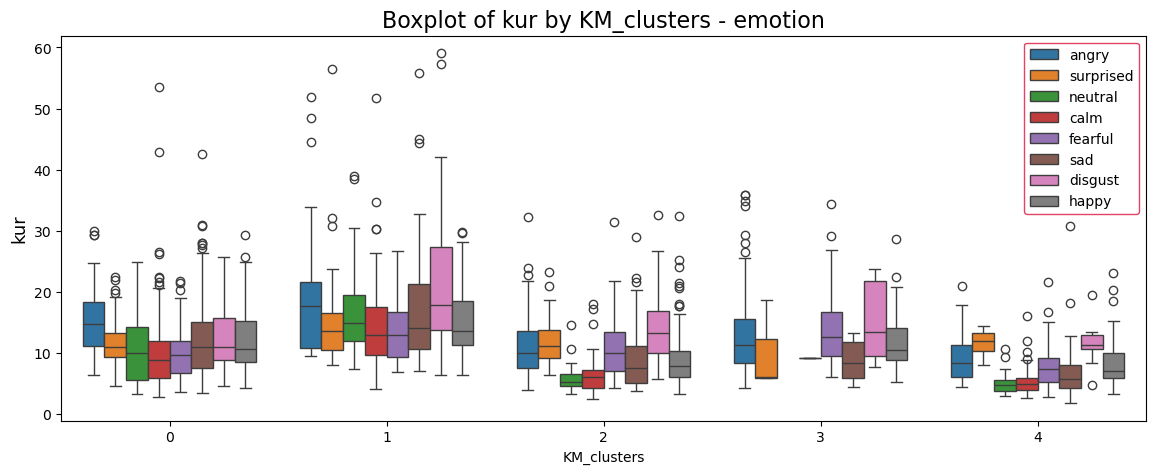

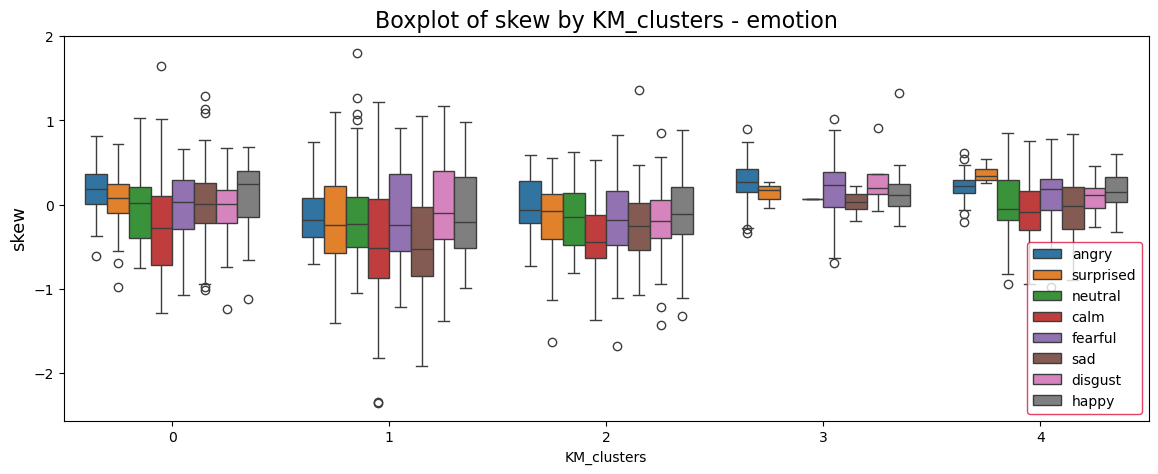

In [25]:
hue = 'emotion'
target = 'KM_clusters'

for col in numeric_cols:
    
    fig, ax = plt.subplots(figsize = (14, 5))
    
    df_temp = df_cluster[[col, target, hue]].melt(id_vars = [target, hue])
    
    sns.boxplot(x = target, y = 'value', hue = hue, data = df_temp, ax = ax)
    #sns.violinplot(x = target, y = 'value', hue = hue, data = df_temp, ax = ax, split = False, inner = 'box')
    ax.set_title(f'Boxplot of {col} by {target} - {hue}', fontsize = 16)
    plt.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10)
    ax.set_ylabel(col, fontsize = 13)
    plt.show()

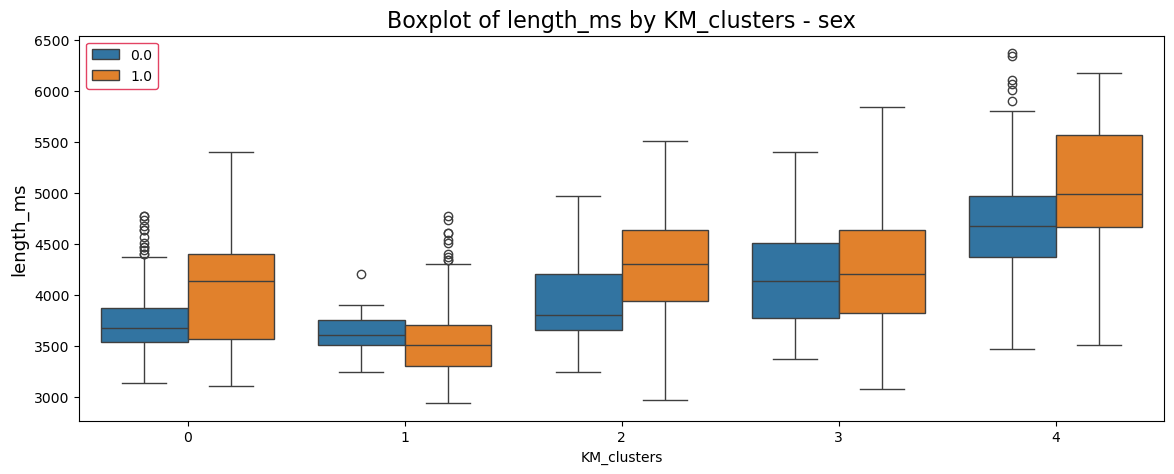

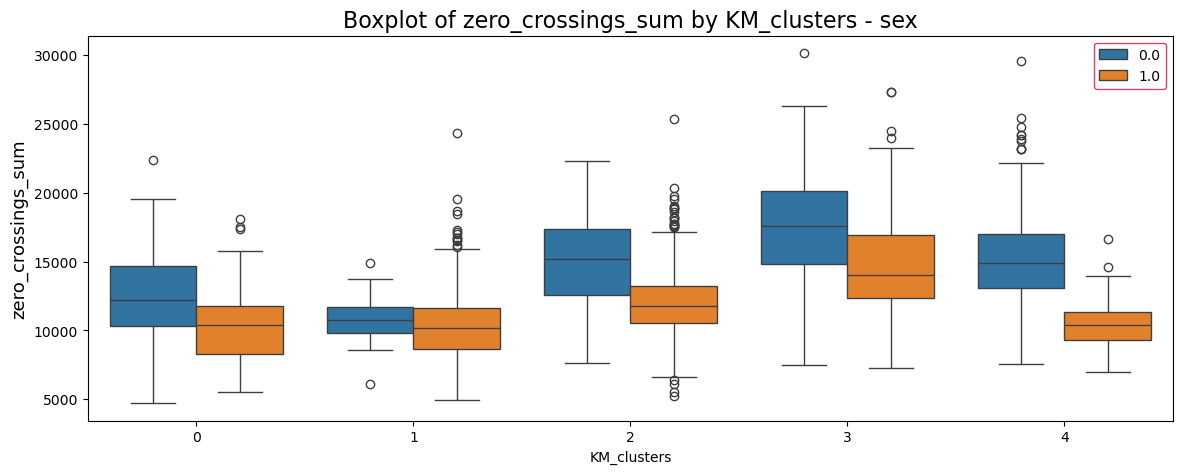

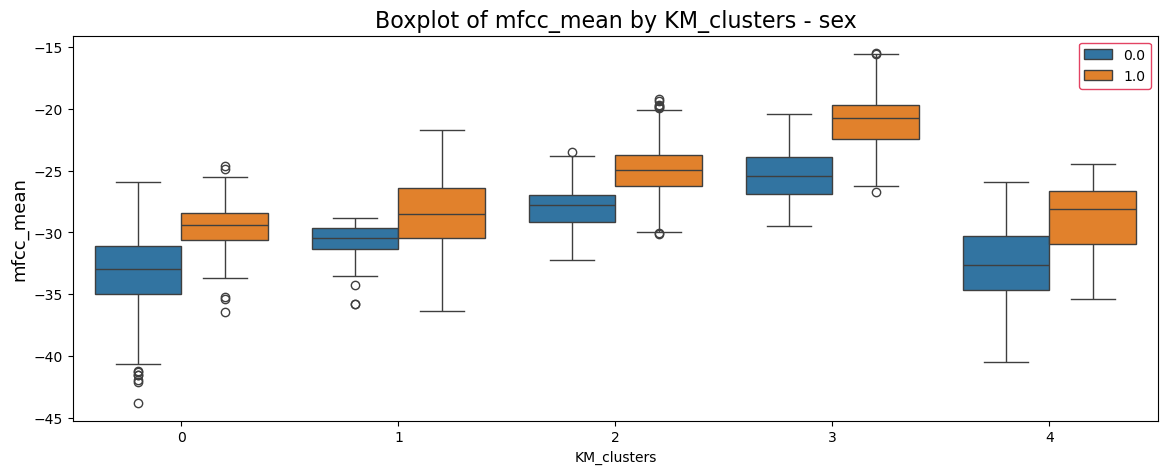

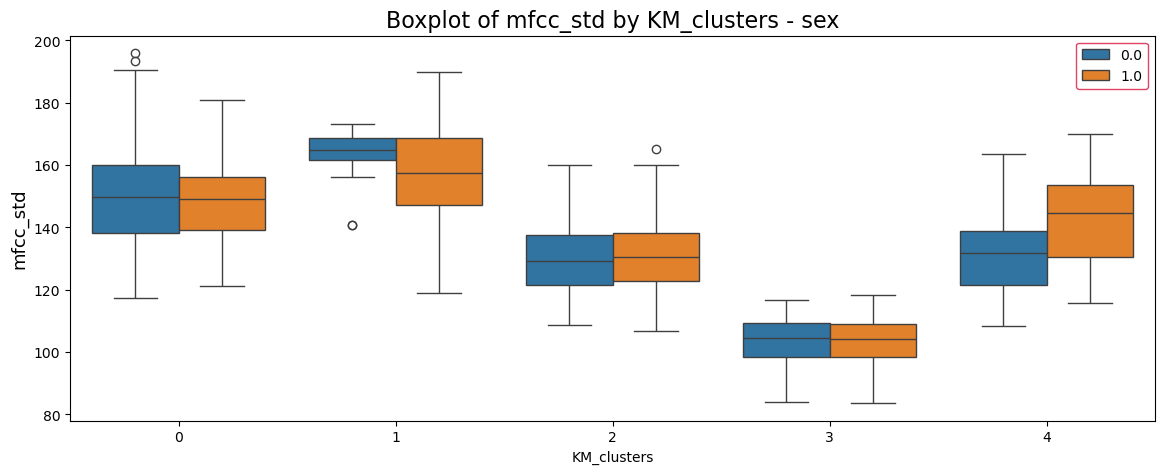

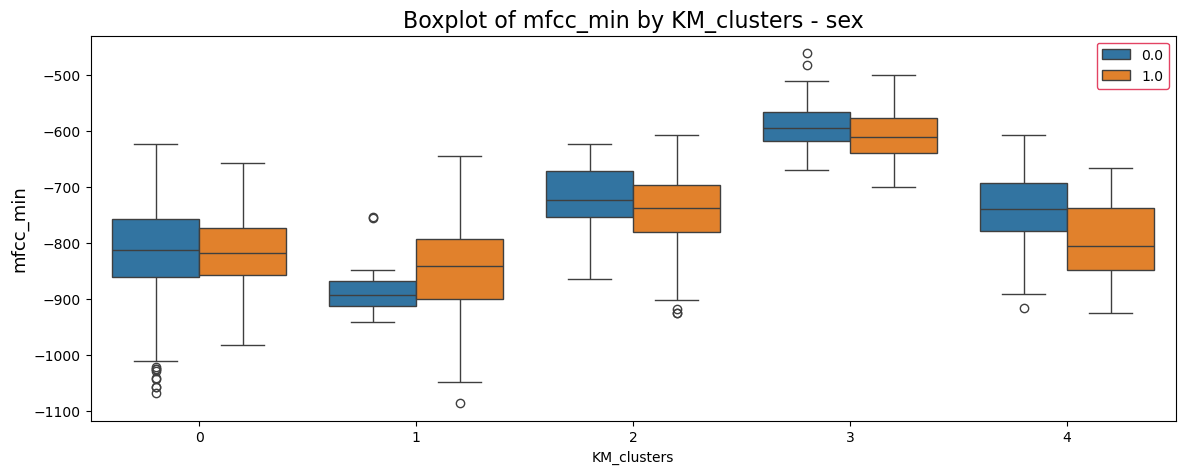

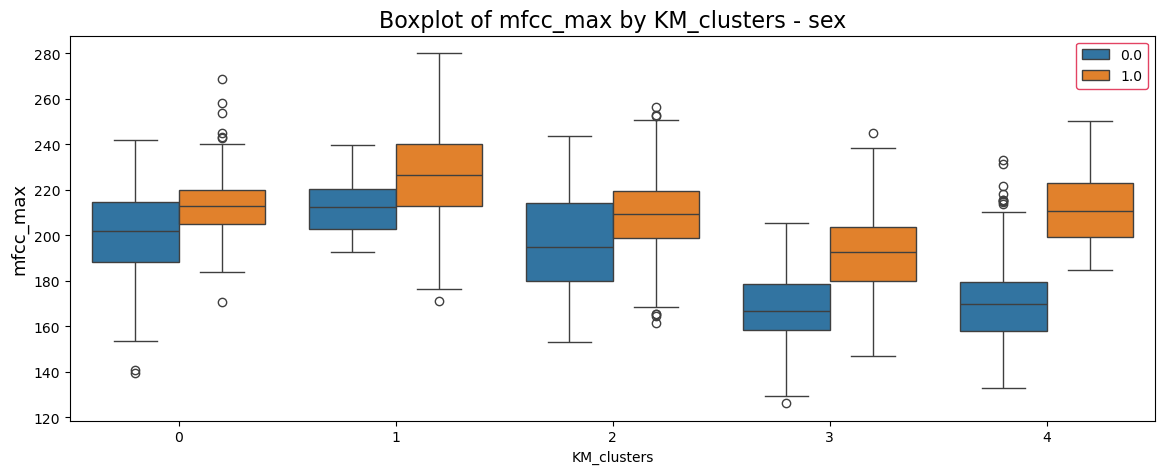

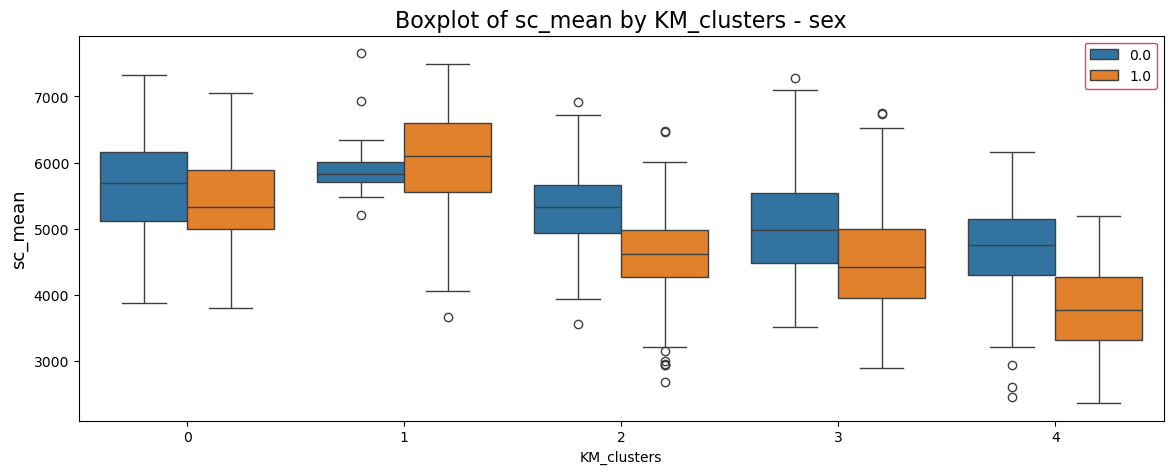

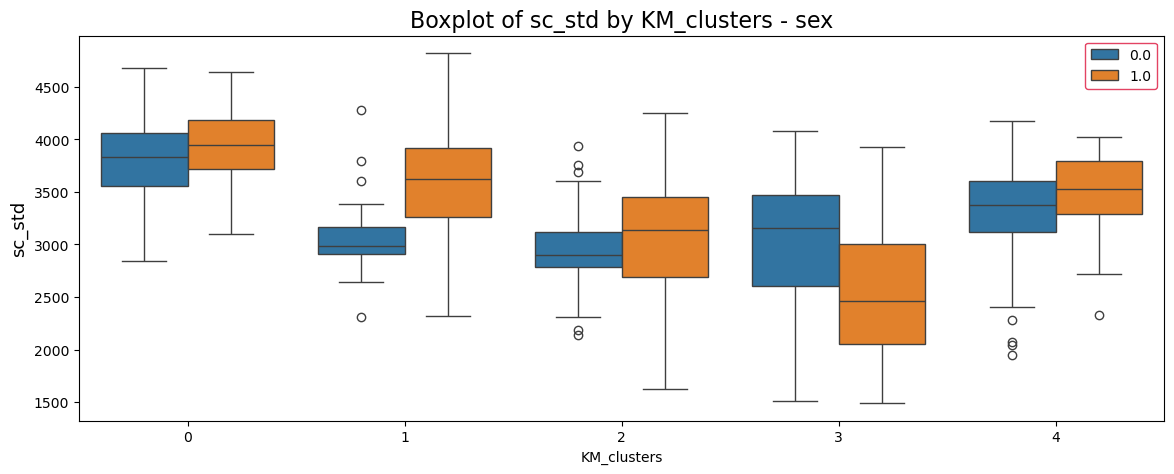

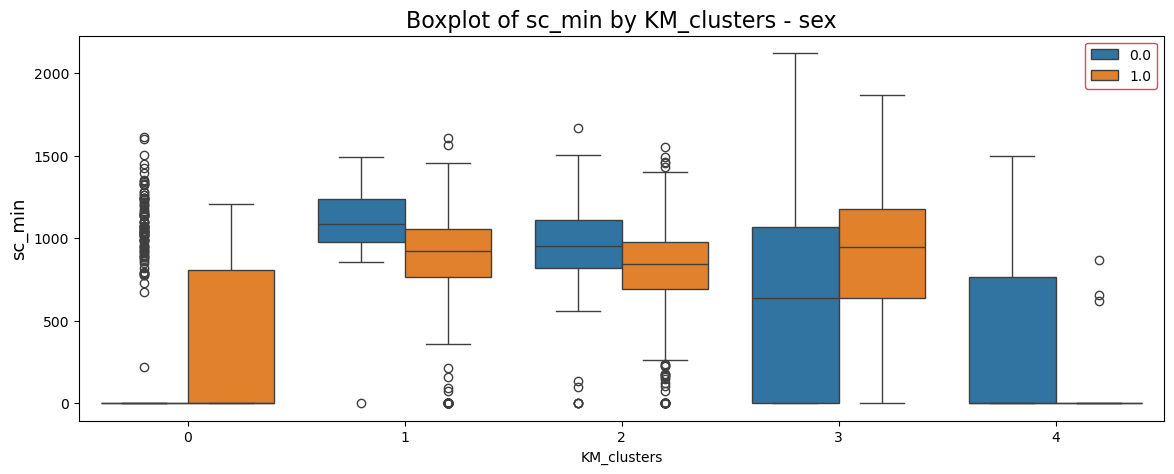

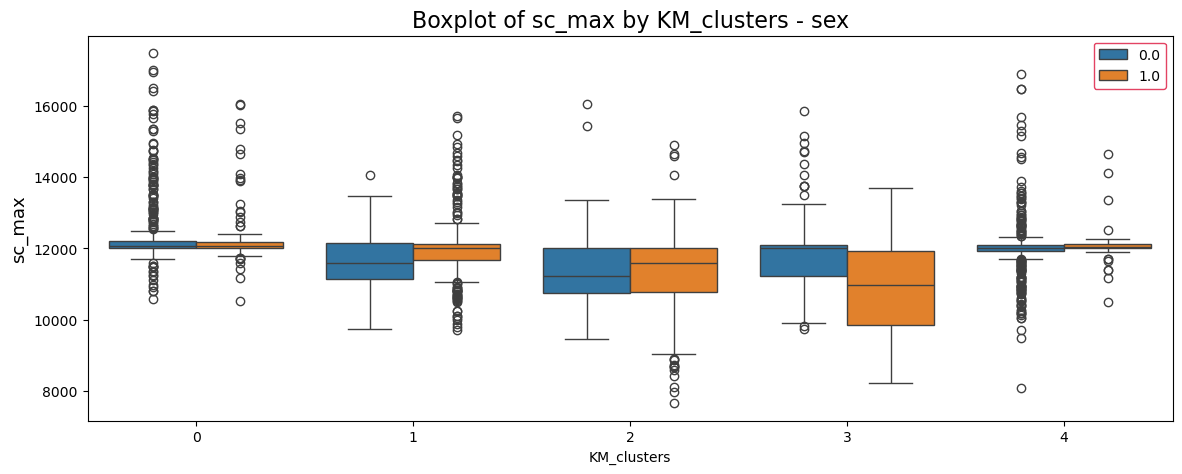

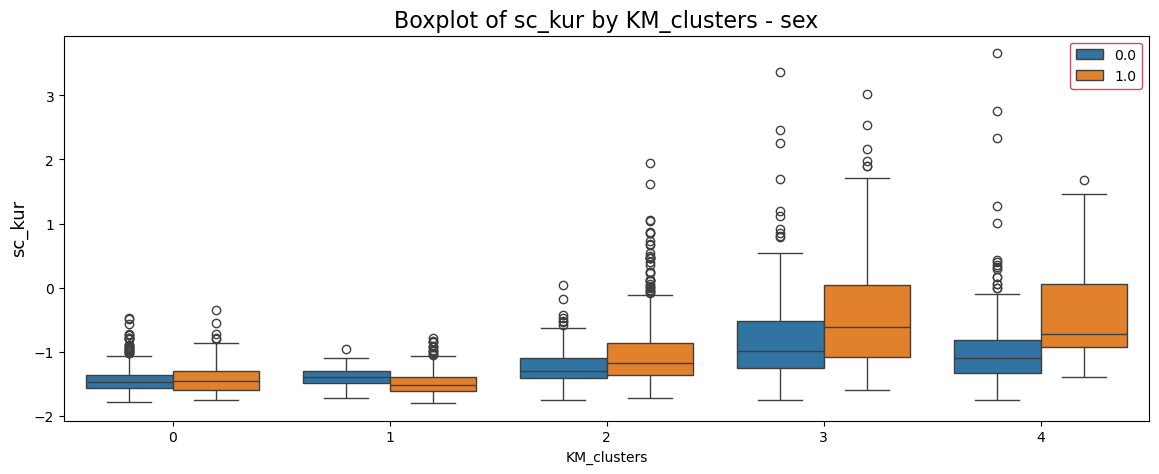

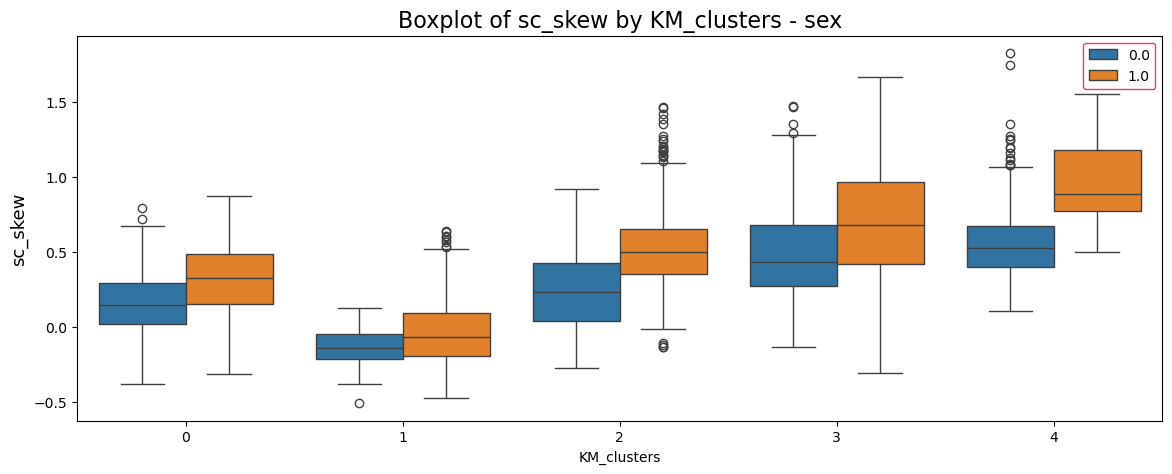

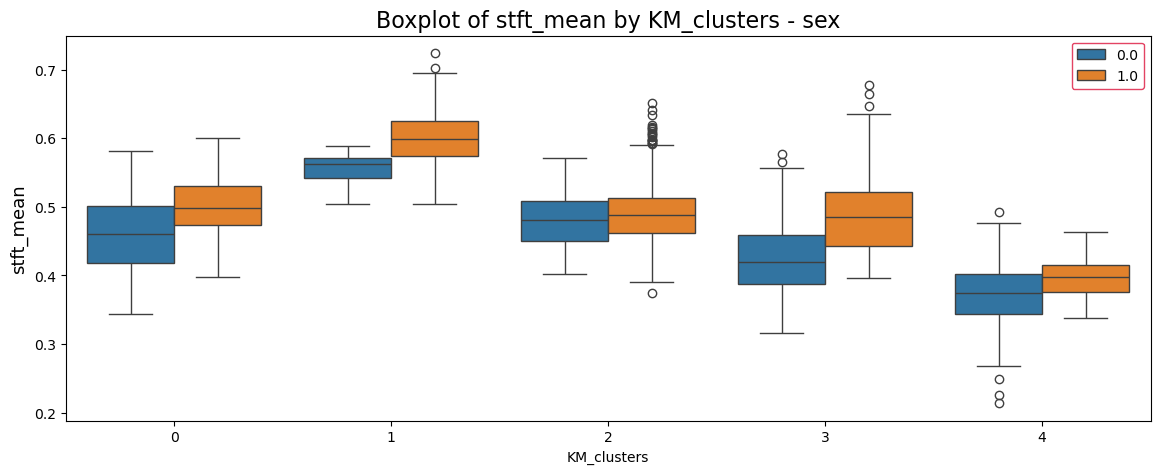

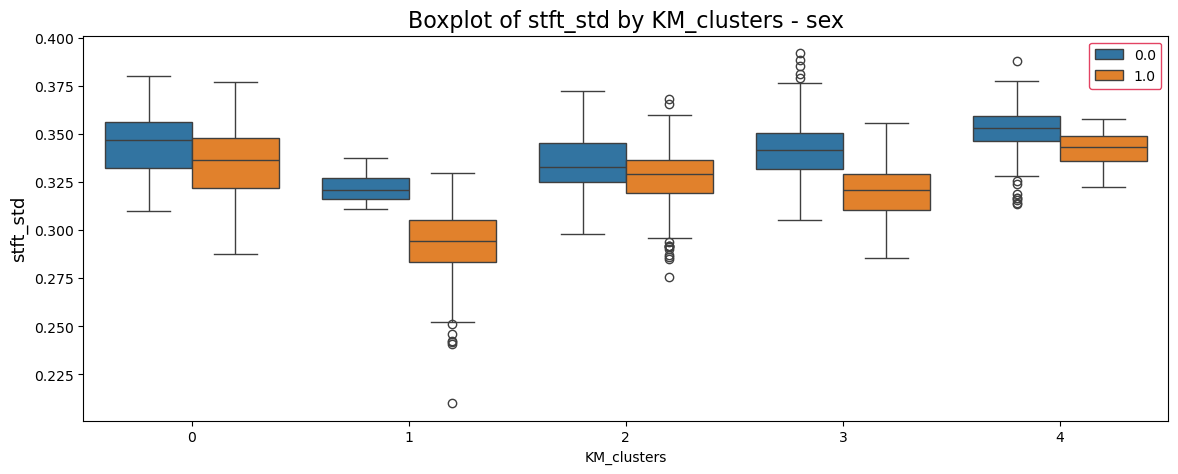

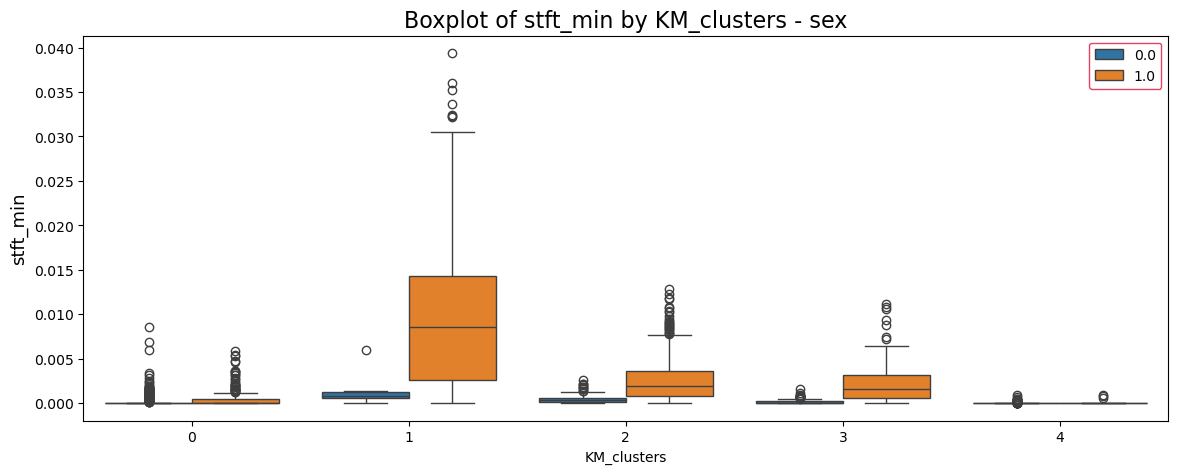

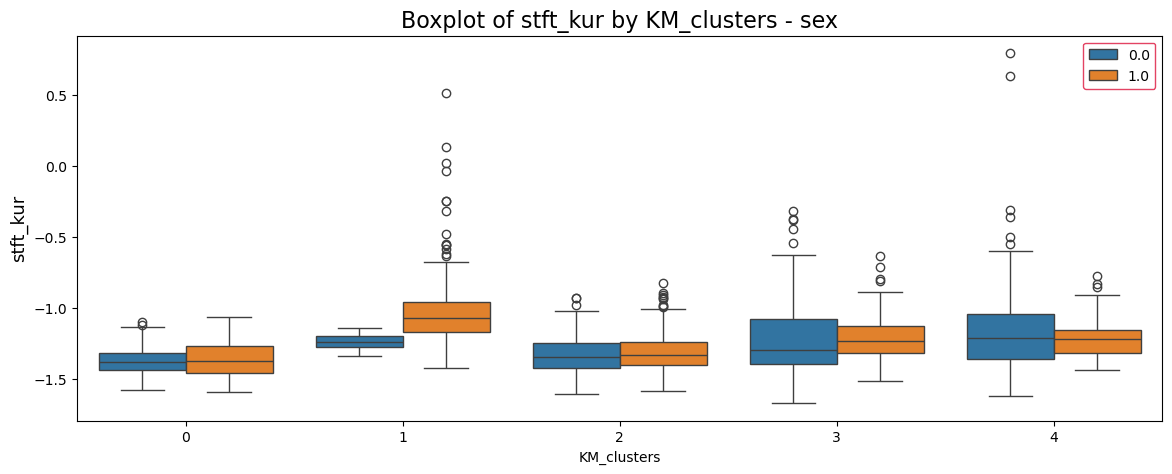

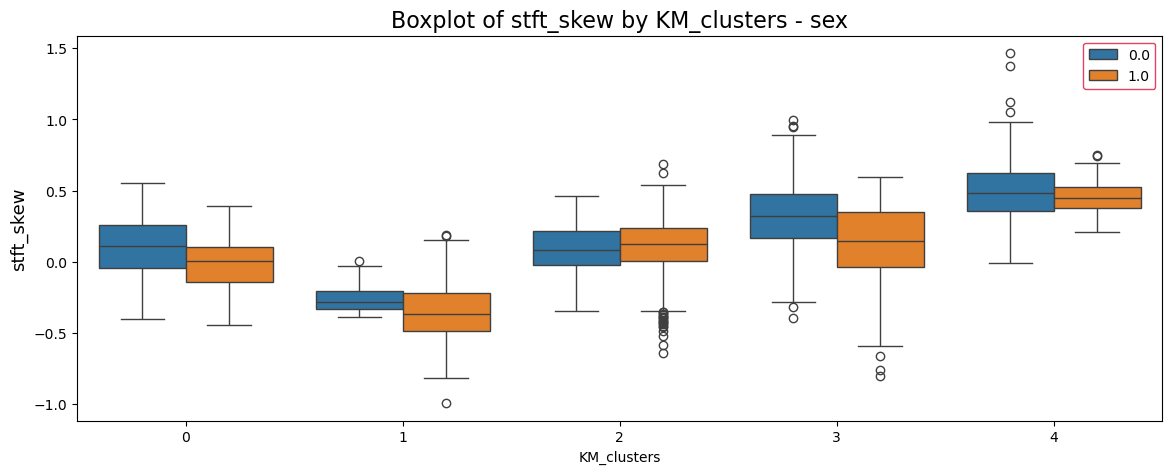

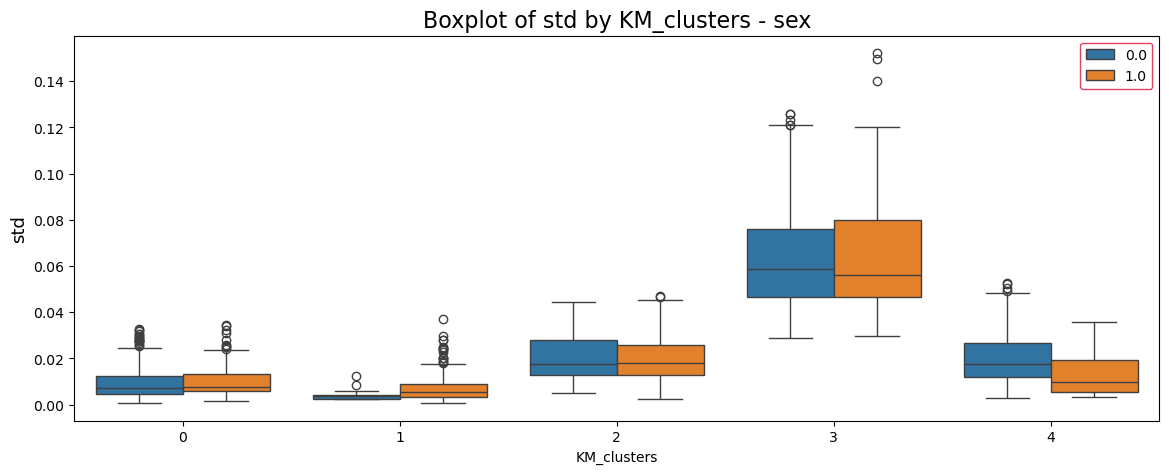

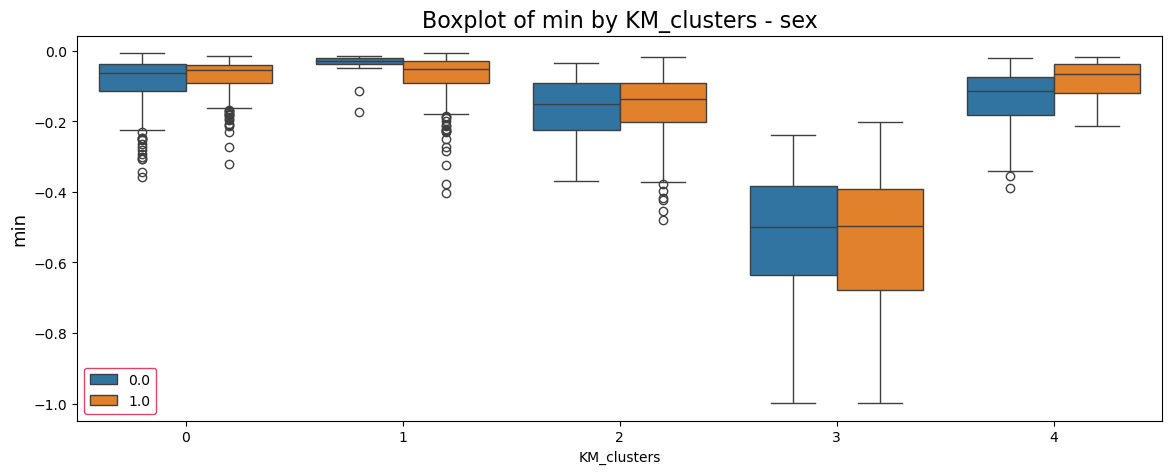

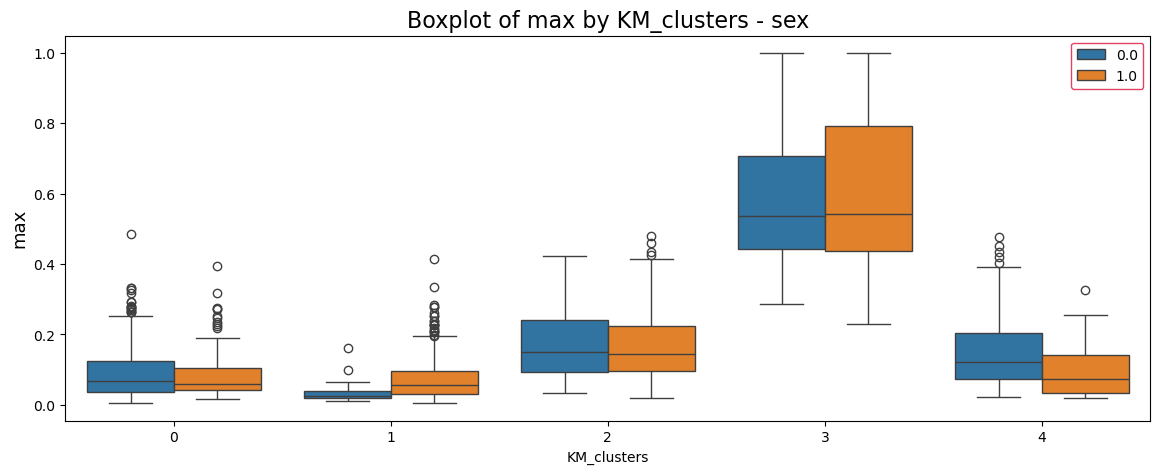

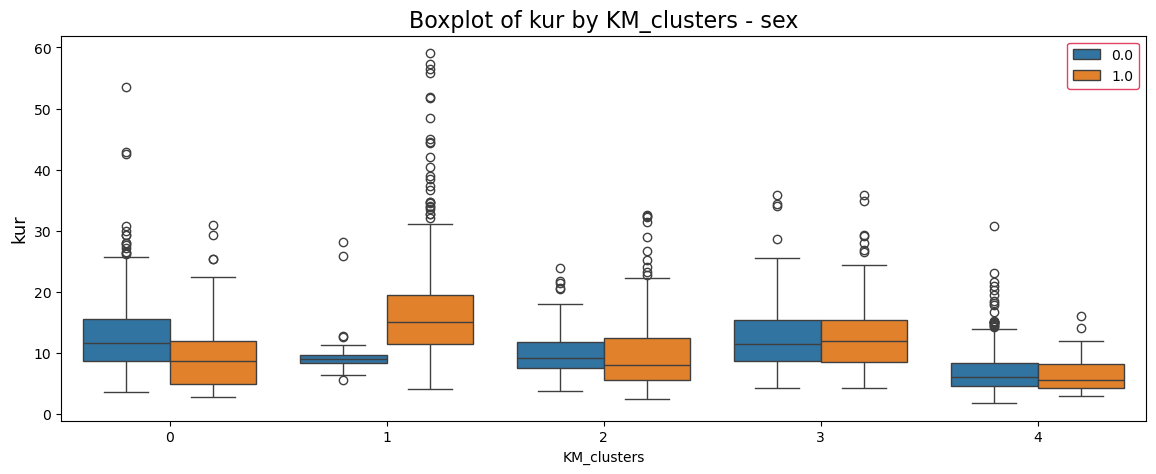

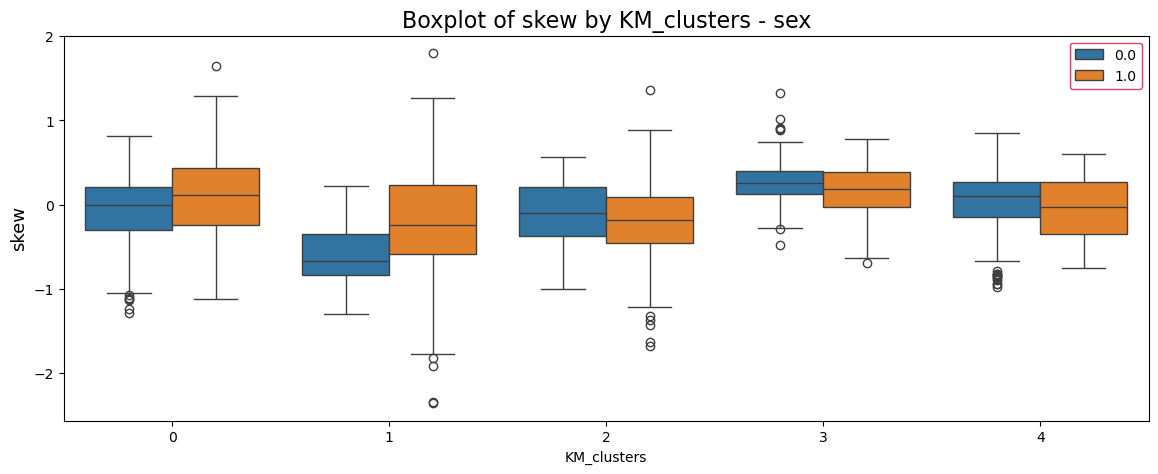

In [26]:
hue = 'sex'
target = 'KM_clusters'

for col in numeric_cols:
    
    fig, ax = plt.subplots(figsize = (14, 5))
    
    df_temp = df_cluster[[col, target, hue]].melt(id_vars = [target, hue])
    
    sns.boxplot(x = target, y = 'value', hue = hue, data = df_temp, ax = ax)
    #sns.violinplot(x = target, y = 'value', hue = hue, data = df_temp, ax = ax, split = False, inner = 'box')
    ax.set_title(f'Boxplot of {col} by {target} - {hue}', fontsize = 16)
    plt.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10)
    ax.set_ylabel(col, fontsize = 13)
    plt.show()

Infine analizziamo il **parallel coordinates** sui centroidi e notiamo che, anche se con oscillazioni di ampiezza diversa, su qualche features abbiamo un comportamento simile dei **centroidi dei cluster 3 e 4** e un comportamento simile dei **centroidi dei cluster 3 e 2**.

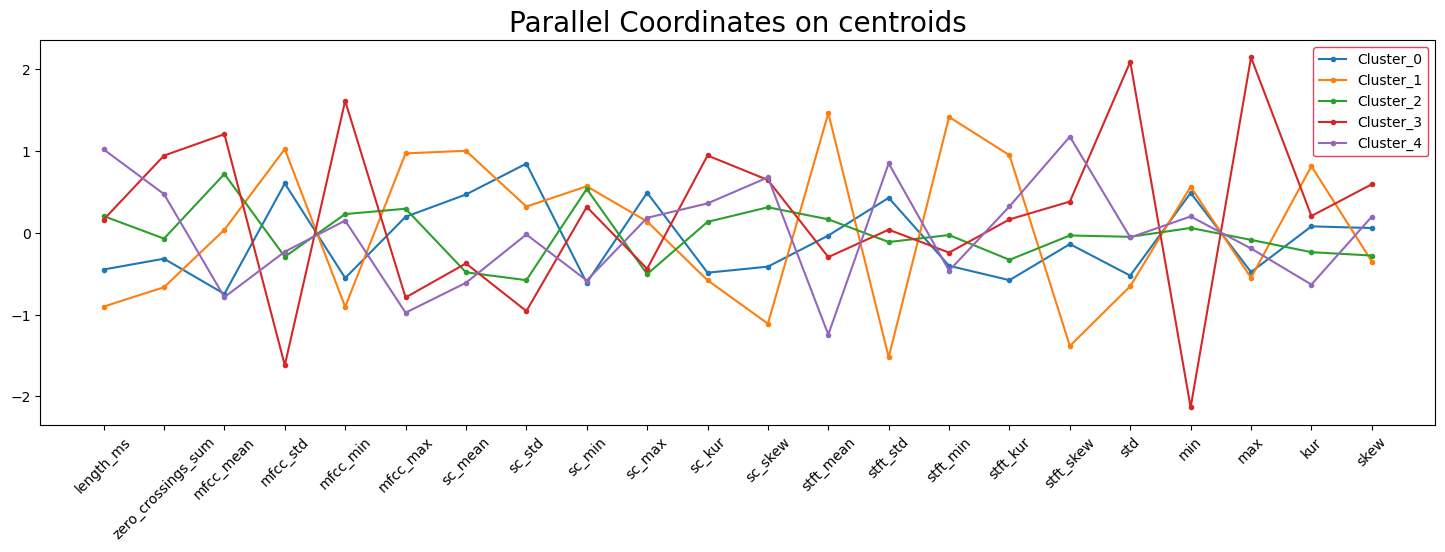

In [27]:
plt.figure(figsize = (18, 5))
for l in np.unique(kmeans.labels_):
    plt.plot(numeric_cols, kmeans.cluster_centers_[l], marker = '.', label = 'Cluster_' + str(l))

plt.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10)
# Rotate x-axis labels
plt.xticks(rotation=45)
plt.title('Parallel Coordinates on centroids', fontsize = 20)
plt.show()

# DBSCAN

Una prima difficoltà che appare è il fatto che la nuvola di punti è piuttosto compatta e a primo impatto non sembrano esserci zone ad alta densità intervallate da zone a bassa densità.

Tuttavia il **DBSCAN** demarca la fine di un cluster e l'inizio di un altro in corrispondenza di un **density drop**.
Il rischio è che tutti i punti siano indistintamente inseriti nel solito grande cluster.

Alla luce di tale complessità prima di procedere a tentativi sulla determinazione di:

- MinPts --> minimo numero di punti in un intorno di raggio $\epsilon$ per decretare che un punto è **core**

- $\epsilon$ --> raggio che sancisce la distanza radiale entro cui cercare almeno **MinPts** per decretare che un punto è **core**

è opportuno visualizzare l'andamento della **distanza dall'n-esimo vicino** con **n corrispondente a MinPts**. Questo ci permette di scegliere consapevolmente MinPts ed $\epsilon$, in modo da avere un buon numero di **core points**.

Per farlo sfruttiamo la matrice delle distanze, calcolata con la **distanza euclidea** in quanto gli attributi coinvolti nel clustering sono continui.

In [28]:
# X è matrice già scalata con StandardScaler con le sole colonne numeriche da considerare come base per il clustering
X

array([[-0.59370043,  1.12146408, -1.05733963, ..., -0.2091685 ,
        -0.27170749,  0.70663217],
       [-0.31452936,  0.27852801, -0.16429762, ...,  0.42569433,
         1.26425838,  0.74841435],
       [ 0.96765158,  1.59300617, -0.39526838, ..., -0.06898976,
        -0.95588585,  0.77150368],
       ...,
       [ 1.91716757, -0.85148114,  0.59043138, ..., -0.42240248,
        -0.94332397,  0.09327539],
       [-0.59370043, -0.86485242,  0.11799329, ..., -0.65390028,
         0.40108606, -0.13789756],
       [-0.42653212, -0.94371565, -0.05605405, ..., -0.39289938,
         0.26766114,  2.37522233]])

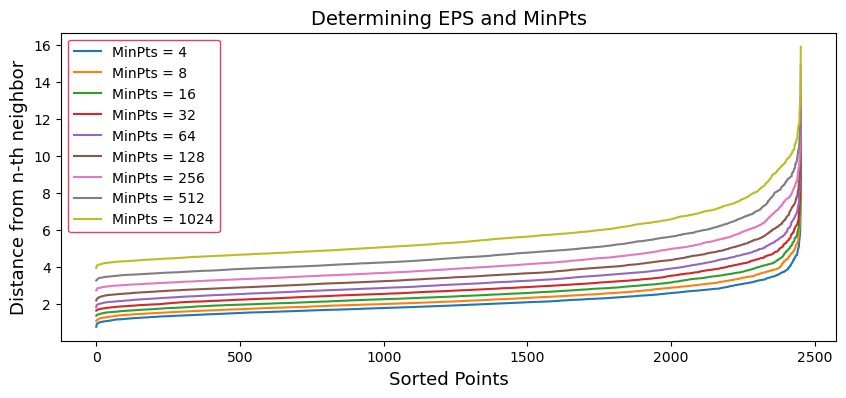

In [29]:
fig, ax = plt.subplots(figsize = (10, 4))

for min_pts in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    min_pts_distance = []
    for i in range(len(X)):
        neigh_idx = np.argsort(D[i])[min_pts]
        min_pts_distance.append(D[i, neigh_idx])

    ax.plot(range(len(X)), sorted(min_pts_distance), label=f'MinPts = {min_pts}' )

ax.set_ylabel('Distance from n-th neighbor', fontsize = 13)
ax.set_xlabel('Sorted Points', fontsize = 13)

ax.set_title('Determining EPS and MinPts', fontsize = 14)

ax.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10)
plt.show()

In [30]:
from sklearn.cluster import DBSCAN

In [31]:
dbscan = DBSCAN(min_samples = 64, eps = 4)
dbscan.fit(X)

DBSCAN(eps=4, min_samples=64)

In [32]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [33]:
label, sizes = np.unique(dbscan.labels_, return_counts = True)

# zip mi fa fare un ciclo for contemporanemente su più vettori ma devono avere la stessa lunghezza
for l, s in zip(label, sizes):
    print('Cluster %s, size %s (%.2f)' % (l, s, s/len(X)))

Cluster -1, size 83 (0.03)
Cluster 0, size 2369 (0.97)


In [34]:
df_cluster['DBScan_clusters'] = dbscan.labels_
df_cluster.head()

length_ms  zero_crossings_sum  mfcc_mean    mfcc_std   mfcc_min   mfcc_max  \
0     3737.0             16995.0 -33.485947  134.654860 -755.22345  171.69092   
1     3904.0             13906.0 -29.502108  130.485630 -713.98560  205.00770   
2     4671.0             18723.0 -30.532463  126.577110 -726.06036  165.45653   
3     3637.0             11617.0 -36.059555  159.725160 -842.94635  190.03609   
4     4404.0             15137.0 -31.405996  122.125824 -700.70276  161.13400   

       sc_mean       sc_std  sc_min        sc_max    sc_kur   sc_skew  \
0  5792.550744  3328.055457     0.0  13541.959028 -1.120769  0.250940   
1  5197.620555  4040.931570     0.0  12000.290443 -1.531204  0.219582   
2  4830.743037  3332.131300     0.0  12007.751173 -1.130153  0.436699   
3  5376.446478  4053.663073     0.0  12048.223893 -1.497765  0.098802   
4  5146.012474  3442.724109     0.0  12025.582707 -1.167544  0.496066   

   stft_mean  stft_std  stft_min  stft_kur  stft_skew       std       min  \
0   0.415250  0.335533       0.0 -1.215025   0.403514  0.014482 -0.128632   
1   0.417488  0.352380       0.0 -1.384174   0.290905  0.020417 -0.305725   
2   0.379758  0.352270       0.0 -1.242947   0.470350  0.024317 -0.137482   
3   0.407277  0.360552       0.0 -1.445318   0.274756  0.003561 -0.027374   
4   0.415974  0.350655       0.0 -1.366742   0.318926  0.027522 -0.192169   

        max        kur      skew  sex    emotion  KM_clusters  DBScan_clusters  
0  0.138947   9.406061  0.273153  0.0    fearful            4                0  
1  0.263062  19.564187  0.292157  0.0      angry            0                0  
2  0.166351   4.881241  0.302659  0.0      happy            4                0  
3  0.024078  13.040259 -0.081014  0.0  surprised            0                0  
4  0.242676   7.485109  0.414872  0.0      happy            4                0

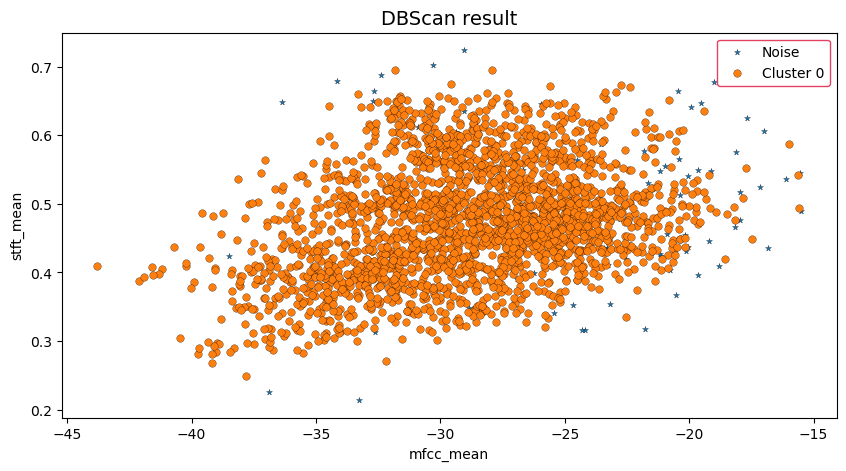

In [35]:
x = 'mfcc_mean'
y = 'stft_mean'

fig, ax = plt.subplots(figsize = (10, 5))

for l in sorted(df_cluster['DBScan_clusters'].unique()):
    if l == -1:
        label = 'Noise'
        size = 20
        marker = '*'
    else:
        label = 'Cluster ' + str(l)
        size = 30
        marker = 'o'
        
    plt.scatter(df_cluster[df_cluster['DBScan_clusters'] == l][x],
                df_cluster[df_cluster['DBScan_clusters'] == l][y], label = label, s = size,
                edgecolor = 'black', linewidth = 0.2, marker = marker)

ax.legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title('DBScan result', fontsize = 14)
plt.show()

Nonostante i numerosi tentativi, non sembra esserci una combinazione di parametri che consenta di ottenere una situazione migliore di quella mostrata in figura. Infatti la condizione alla base del **DBScan** per decretare la fine di un cluster e l'inizio del successivo, ovvero i crollo di densità nei dati, non sembra essere una caratteristica di questo dataset. Pertanto sembra che non sarà possibile ottenere una situazione migliore di questa: **un solo cluster** + qualche **noise** ai bordi della nuvola.

Calcolo il centro dell'unico cluster ottenuto.

In [36]:
def calc_centers(X, labels):
    centers = []
    for l in sorted(np.unique(labels)):
        if l == -1: # serve per il DBSCAN in cui il NOISE lo mette in classe -1
            continue
        mask = labels
        centers.append(np.mean(X[mask], axis = 0))
    return centers

In [37]:
centers_dbscan = calc_centers(X, dbscan.labels_)
centers_dbscan

[array([-0.5880418 ,  1.05155791, -1.0234462 , -0.07973562,  0.02188472,
        -0.99521152,  0.72258861, -0.02736328, -1.08645385,  1.6581862 ,
         0.01570157, -0.28617435, -0.67690045,  0.15412062, -0.47041363,
         0.1485841 ,  0.81319958, -0.29372915,  0.21569372, -0.21538778,
        -0.25344991,  0.76311381])]

Come temuto il **DBScan** fallisce a causa dell'assenza di un drop nella **densità**.

# Clustering Gerarchico

In [38]:
# X è matrice già scalata con StandardScaler con le sole colonne numeriche da considerare come base per il clustering
X

array([[-0.59370043,  1.12146408, -1.05733963, ..., -0.2091685 ,
        -0.27170749,  0.70663217],
       [-0.31452936,  0.27852801, -0.16429762, ...,  0.42569433,
         1.26425838,  0.74841435],
       [ 0.96765158,  1.59300617, -0.39526838, ..., -0.06898976,
        -0.95588585,  0.77150368],
       ...,
       [ 1.91716757, -0.85148114,  0.59043138, ..., -0.42240248,
        -0.94332397,  0.09327539],
       [-0.59370043, -0.86485242,  0.11799329, ..., -0.65390028,
         0.40108606, -0.13789756],
       [-0.42653212, -0.94371565, -0.05605405, ..., -0.39289938,
         0.26766114,  2.37522233]])

In [39]:
# Matrice delle distanze sparsa, in forma vettoriale, salva un sacco di spazio.
D_sparse = pdist(X)
D_sparse

array([3.66167418, 2.94395837, 3.77014013, ..., 4.88642629, 4.78186685,
       3.2973708 ])

In [40]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

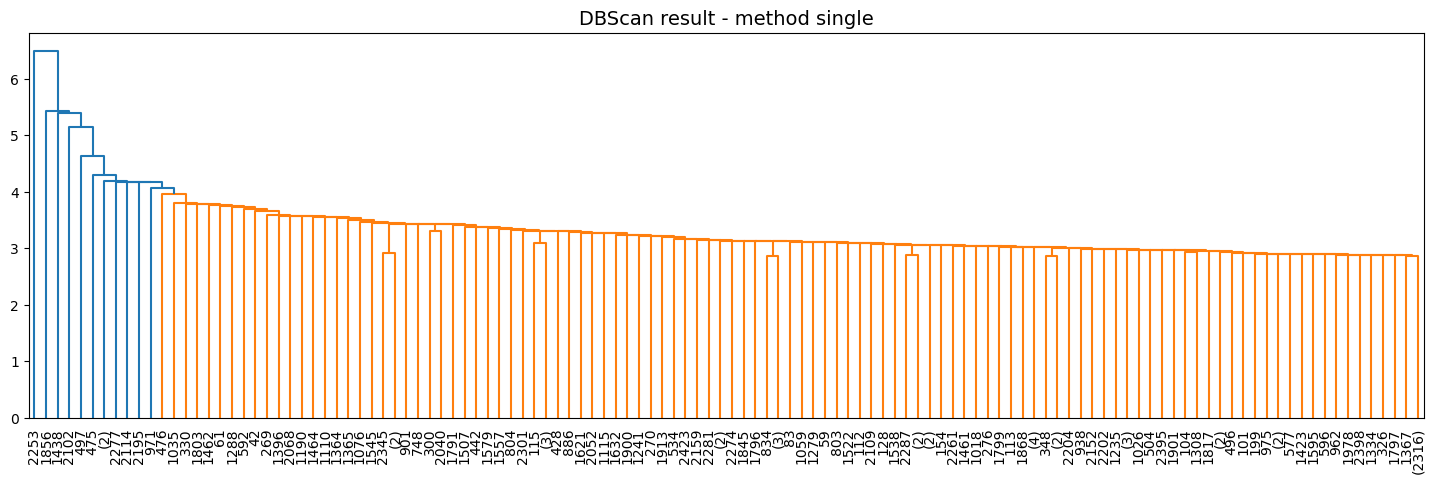

In [41]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

method = 'single'

single_link = linkage(D_sparse, method = method)

plt.figure(figsize = (18, 5))
dendrogram = dendrogram(single_link, color_threshold = 4, p = 120, truncate_mode = 'lastp')
plt.title(f'DBScan result - method {method}', fontsize = 14)
plt.xticks(fontsize = 10)
plt.show()

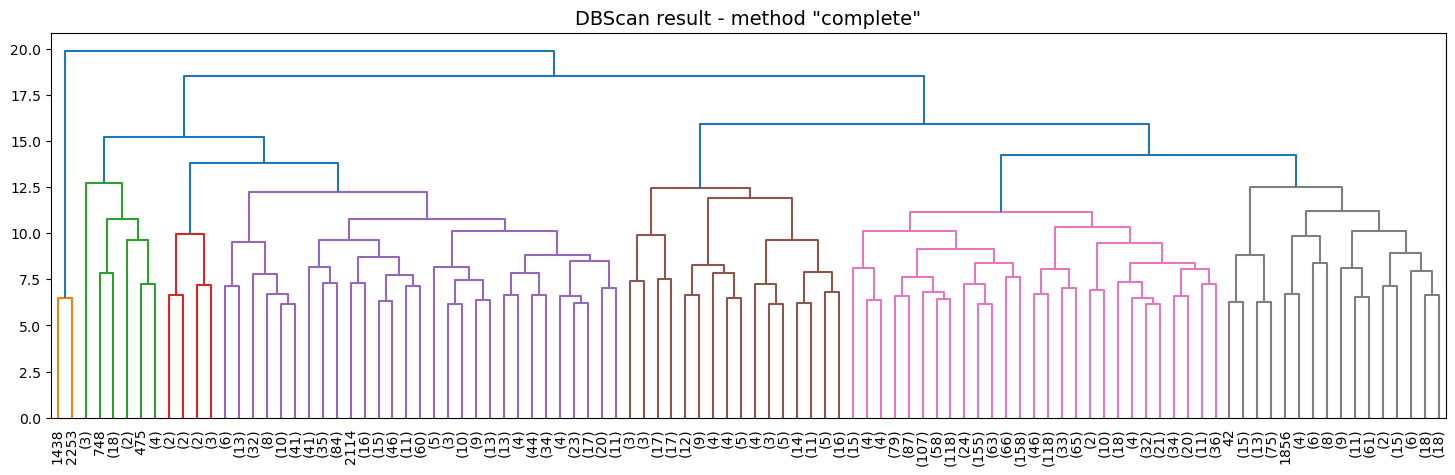

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

method = 'complete'

complete_link = linkage(D_sparse, method = method)

plt.figure(figsize = (18, 5))
dendrogram = dendrogram(complete_link, color_threshold = 13, p = 100, truncate_mode = 'lastp')
plt.title(f'DBScan result - method "{method}"', fontsize = 14)
plt.xticks(fontsize = 10)
plt.show()

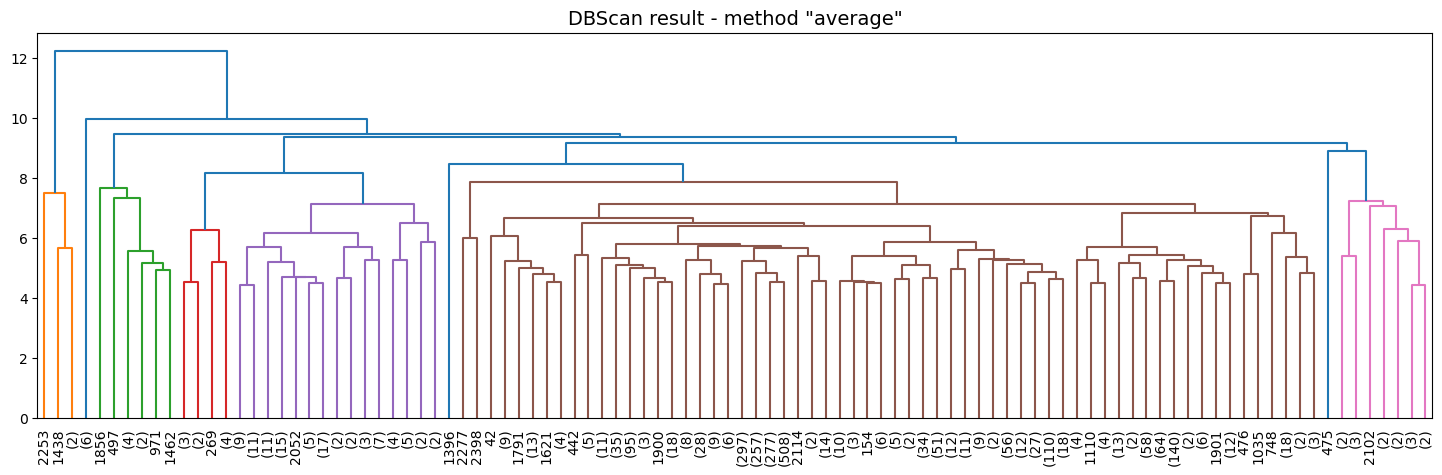

In [43]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

method = 'average'

avg_link = linkage(D_sparse, method = method)

plt.figure(figsize = (18, 5))
dendrogram = dendrogram(avg_link, color_threshold = 8, p = 100, truncate_mode = 'lastp')
plt.title(f'DBScan result - method "{method}"', fontsize = 14)
plt.xticks(fontsize = 10)
plt.show()

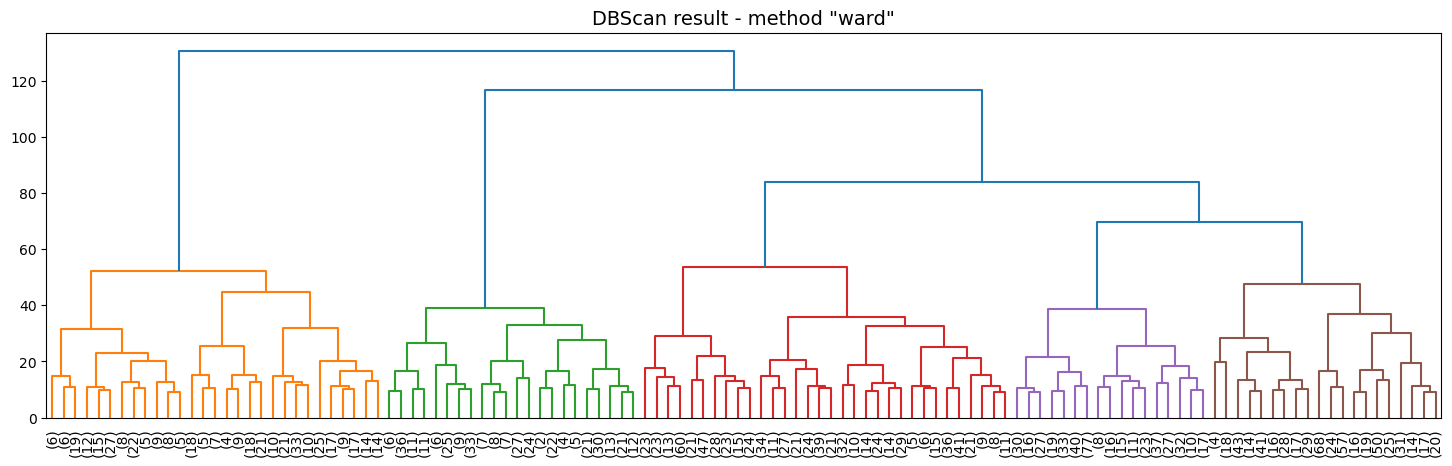

In [44]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

method = 'ward'

ward_link = linkage(D_sparse, method = method)

plt.figure(figsize = (18, 5))
dendrogram = dendrogram(ward_link, color_threshold = 60, p = 120, truncate_mode = 'lastp')
plt.title(f'DBScan result - method "{method}"', fontsize = 14)
plt.xticks(fontsize = 10)
plt.show()

Si nota che per ottenere un numero di clusters paragonabile utilizzando i 4 metodi, si deve impostare un valore di **threshold sulla distanza di taglio** piuttosto differente. In particolare notiamo che nel **single linkage** e nell'**average** tale valore è più contenuto e sotto 10. Saliamo leggermente sopra 10 nel caso del **complete linkage**. Il metodo **ward** è un caso a parte in quanto la threshold impostata è sopra 50.

Adesso procediamo con il taglio effettivo per i vari metodi con la funzione **fcluster(links, t)** dove **t è la THRESHOLD** su cui ho precedentemente ragionato grazie al parametro color_threshold. Visualizziamo ogni volta il risultato per vedere che cluster otteniamo:

In [45]:
labels_single = fcluster(single_link, t = 4.5, criterion = 'distance')
print(np.unique(labels_single))

df_cluster['SingLink_clusters'] = labels_single

[1 2 3 4 5 6]


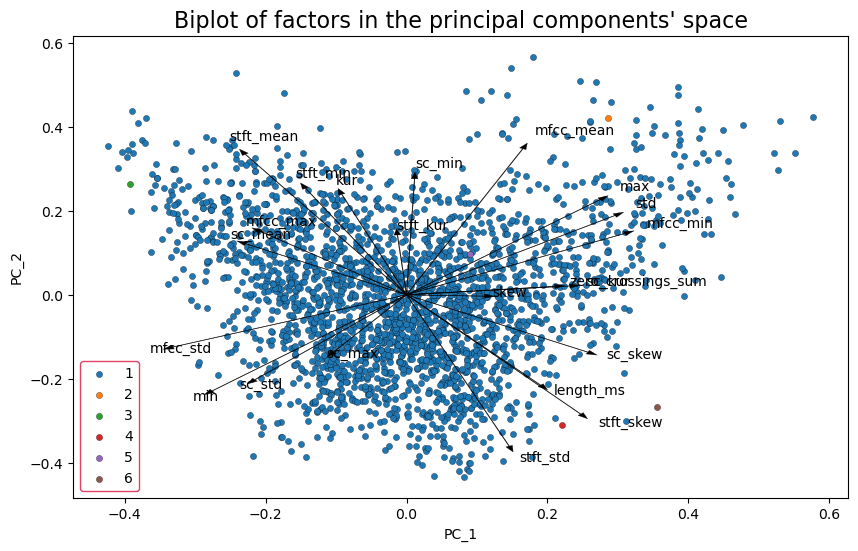

In [46]:
biplot(PC = X_pca,
        # with the transposition the eigenvectors V are on columns
        principal_directions = prin_dir.T,
        list_variable_names = numeric_cols,
        by_class_values = df_cluster['SingLink_clusters'],
        idx_1 = 0, idx_2 = 1)

**Single Link** sembra non funzionare correttamente perché scendendo con il taglio per **aumentare il numero di clusters**, il solo effetto che otteniamo è quello di creare dei **singleton** poco significativi. Questo metodo sembra fallire.

In [47]:
labels_complete = fcluster(complete_link, t = 13, criterion = 'distance')
print(np.unique(labels_complete))

df_cluster['CompLink_clusters'] = labels_complete

[1 2 3 4 5 6 7]


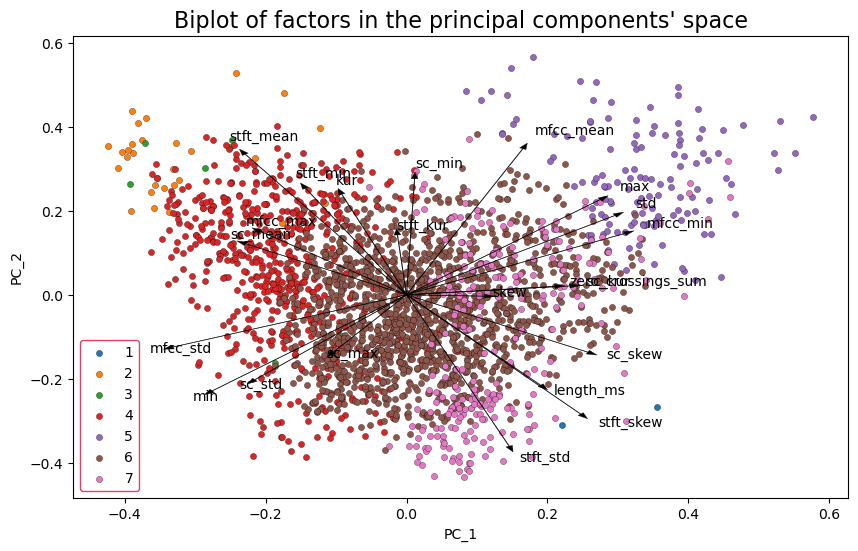

In [48]:
biplot(PC = X_pca,
        # with the transposition the eigenvectors V are on columns
        principal_directions = prin_dir.T,
        list_variable_names = numeric_cols,
        by_class_values = df_cluster['CompLink_clusters'],
        idx_1 = 0, idx_2 = 1)

**Complete Link** sembra fare un lavoro molto migliore.

In [49]:
labels_avg = fcluster(avg_link, t = 8, criterion = 'distance')
print(np.unique(labels_avg))

df_cluster['AvgLink_clusters'] = labels_avg

[1 2 3 4 5 6 7 8 9]


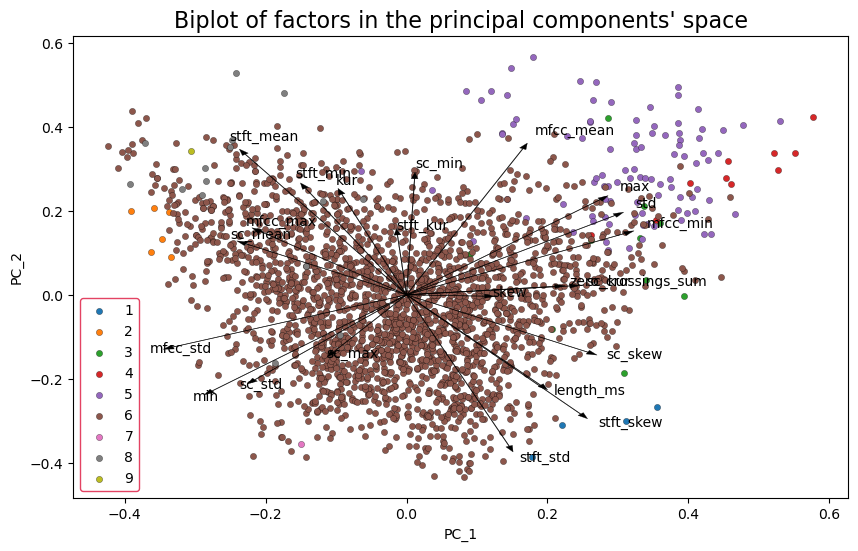

In [50]:
biplot(PC = X_pca,
        # with the transposition the eigenvectors V are on columns
        principal_directions = prin_dir.T,
        list_variable_names = numeric_cols,
        by_class_values = df_cluster['AvgLink_clusters'],
        idx_1 = 0, idx_2 = 1)

**Average Link** tende ad addensare quasi tutti i punti in un grande cluster centrale creando singleton sulla periferia

In [51]:
labels_ward = fcluster(ward_link, t = 60, criterion = 'distance')
print(np.unique(labels_ward))

df_cluster['WardLink_clusters'] = labels_ward

[1 2 3 4 5]


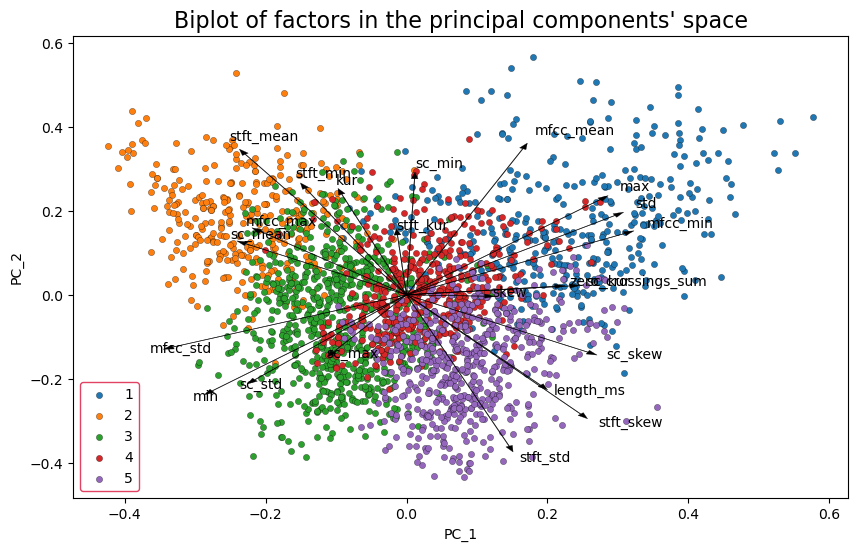

In [52]:
biplot(PC = X_pca,
        # with the transposition the eigenvectors V are on columns
        principal_directions = prin_dir.T,
        list_variable_names = numeric_cols,
        by_class_values = df_cluster['WardLink_clusters'],
        idx_1 = 0, idx_2 = 1)

**Ward** sembra comportarsi molto simile a kmeans, creando cluster piuttosto omogenei e ben distribuiti nello spazio.

Dall'analisi grafica dei cluster, concludiamo che i due migliori algoritmi di clustering gerarchico sono:
- **Ward Link**
- **Complete Link**

In [53]:
# Calcolo dei centri
centers_single = calc_centers(X, labels_single)
centers_complete = calc_centers(X, labels_complete)
centers_avg = calc_centers(X, labels_avg)
centers_ward = calc_centers(X, labels_ward)

# Clustering - Final Evaluation

Per trarre le conclusioni finali sul miglior clustering, abbiamo deciso di fare una valutazione incrociando le seguenti metrich:
- SSE (Sum of Squared Errors) : riflette il concetto di **coesione dei clusters**
- BSS (Between Sum of Squared Error) : riflette il concetto di **separazione dei clusters**
- SILHOUETTE : fa il **match tra coesione e separazione**

Pertanto abbiamo definito tre funzioni che data una **matrice X**, sulla base della matrice delle distanze **squareform(pdist(X))** e date le labels conseguenti ai vari algoritmi, permette di derivare le tre metriche di cui sopra.

In [54]:
from scipy.spatial.distance import cdist

def sse_score(X, labels, return_centers = False):
    cluster_centers = [] # mi creo la lista dei centi che vado pian piano a riempire
    tot_distance = 0.0 # il SSE 
    for l in np.unique(labels):
        if l == -1: # Serve per gestire i NOISE del DBSCAN
            continue
        cluster = X[labels == l] # Solo osservazioni che hanno la label l
        center = cluster.mean(axis = 0) # Medio il valore degli attributi di queste osservazioni ottenendo il CENTROIDE della classe l
        # Mi dà un vettore con tutte le distanze tra le osservazioni che hanno label l e il centroide di quelle stesse osservazini
        # appena calcolato, ovvero center
        dist = cdist(cluster, center.reshape(1,-1))**2
        tot_distance += dist.sum()
        cluster_centers.append(center) # Mi salvo il centroide
    cluster_centers = np.array(cluster_centers)
    if return_centers:
        return tot_distance, cluster_centers
    return tot_distance
    

def bss_score(X, labels):

    cluster_centers = [] # mi creo la lista dei centi che vado pian piano a riempire
    cluster_cardinalities = [] # mi creo la lista della cardinalità di ogni cluster, da riempire
    
    for l in np.unique(labels):
        if l == -1: # Serve per gestire i NOISE del DBSCAN
            continue
            
        cluster = X[labels == l] # Solo osservazioni che hanno la label l
        
        cardinality = cluster.shape[0] # cardinalità del cluster
        center = cluster.mean(axis=0) # Medio il valore degli attributi di queste osservazioni ottenendo il CENTROIDE della classe l
        cluster_cardinalities.append(cardinality)
        cluster_centers.append(center) # Mi salvo il centroide

    # Normalizzo le cardinalità dei singoli clusters rispetto alla dimensione del dataset
    cluster_cardinalities = np.array(cluster_cardinalities) / len(X)
    cluster_centers = np.array(cluster_centers)
    
    data_center = X.mean(axis = 0) # centroide dell'unico grande cluster formato da tutte le osservazioni
    
    # Calcolo della distanza tra i centroidi dei singoli cluster e l'unico grande centroide di tutto il dataset
    dist = cluster_cardinalities.reshape(-1, 1) * cdist(cluster_centers, data_center.reshape(1,-1))**2
    return dist.sum()


def sil_score(X, labels):
    D = squareform(pdist(X))
    sil_samples = sorted(silhouette_samples(D, labels, metric = 'precomputed'))
    return sum(sil_samples) / len(sil_samples)


In [55]:
for alg in ['KM_clusters', 'DBScan_clusters', 'SingLink_clusters', 'CompLink_clusters', 'AvgLink_clusters', 'WardLink_clusters']:
    labels = df_cluster[alg]
    sse, cluster_centers = sse_score(X, labels, return_centers = True)
    bss = bss_score(X, labels)
    silhouette = sil_score(X, labels)
    print('%s \t  SILHOUETTE %.3f   SSE %.2f    BSS %.2f' % (alg[:10], silhouette, sse, bss))

KM_cluster 	  SILHOUETTE 0.156   SSE 30022.45    BSS 9.76
DBScan_clu 	  SILHOUETTE 0.389   SSE 46814.95    BSS 0.03
SingLink_c 	  SILHOUETTE 0.263   SSE 53297.42    BSS 0.26
CompLink_c 	  SILHOUETTE 0.117   SSE 36149.75    BSS 7.26
AvgLink_cl 	  SILHOUETTE 0.176   SSE 45941.15    BSS 3.26
WardLink_c 	  SILHOUETTE 0.106   SSE 32652.54    BSS 8.68


In [56]:
# Verifica che torni la SSE (inertia_) del kmeans
kmeans.inertia_

30022.451383336873

In [57]:
silhouette_score(D, kmeans.labels_, metric = 'precomputed')

0.15564280685095738

Per la valutazione finale abbiamo deciso di analizzare anche la **silhouette per ogni osservazione**, per **ciascuno degli algoritmi** per avere conferma che i valori medi precedentemente osservati NON fossero frutto di una compensazione tra **osservazioni clusterizzate eccezionalmente bene (alta silhouette)** e **osservazioni clusterizzate eccezionalmente male (bassa silhouette)**.

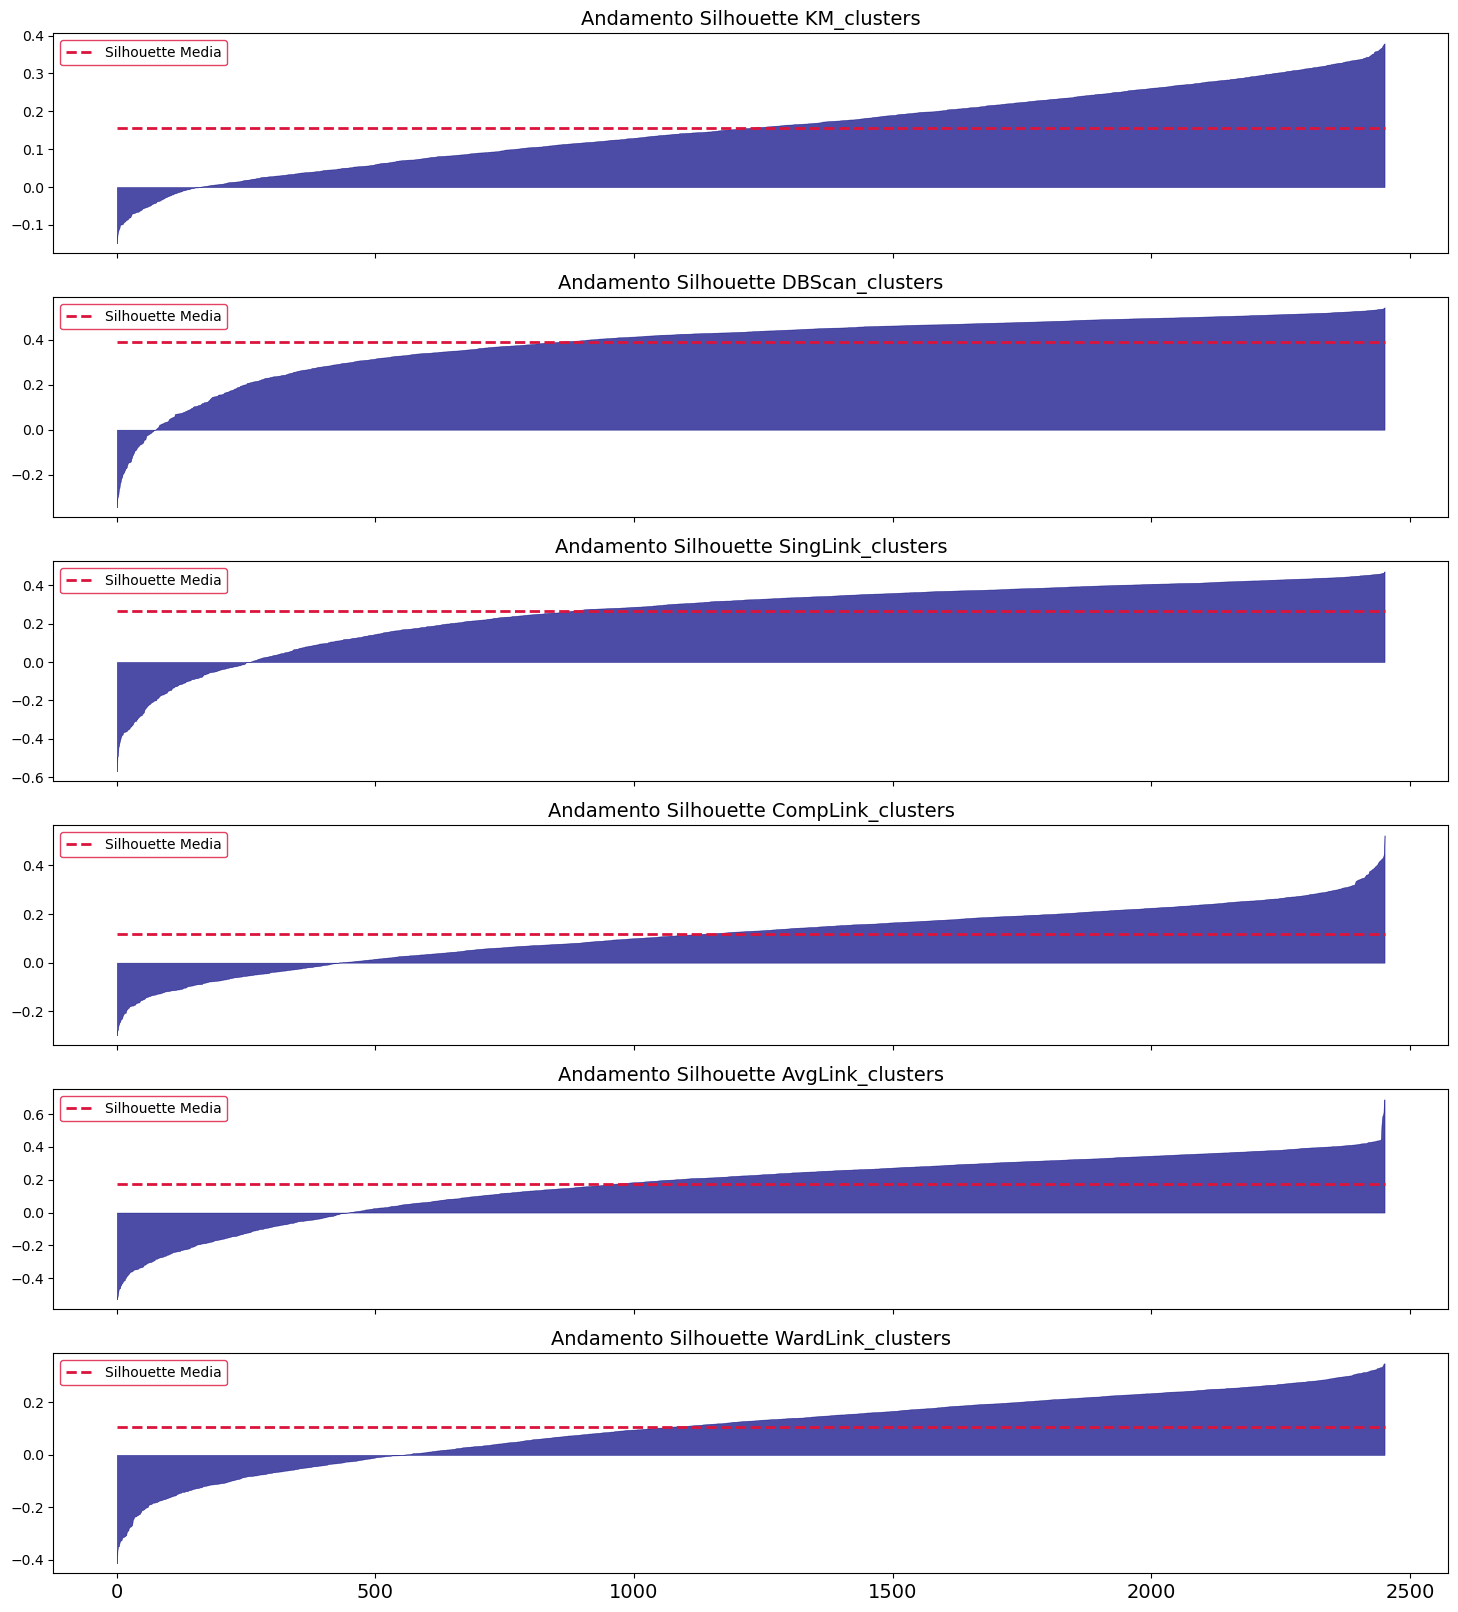

In [58]:
list_algo = ['KM_clusters', 'DBScan_clusters', 'SingLink_clusters', 'CompLink_clusters', 'AvgLink_clusters', 'WardLink_clusters']

# Matrice delle distanze che uso per calcolare la SILHOUETTE
D = squareform(pdist(X))

fig, ax = plt.subplots(len(list_algo), 1, figsize = (18, 20), sharex = True)

for j in range(len(list_algo)):
    # Plotto i risultati di silhouette per ogni osservazione ordinati dai negativi ai positivi
    sil_samples = sorted(silhouette_samples(D, df_cluster[list_algo[j]], metric = 'precomputed'))
    ax[j].fill_between(range(len(sil_samples)), sil_samples, color = 'navy', alpha = 0.7, lw = 0.4)
    ax[j].plot([0, len(sil_samples)], np.mean(sil_samples)*np.ones(2), color = 'crimson', lw = 2, linestyle = '--', label = 'Silhouette Media')
    ax[j].set_title(f'Andamento Silhouette {list_algo[j]}', fontsize = 14)
    ax[j].legend(facecolor = 'white', edgecolor = 'crimson', fontsize = 10, loc = 'upper left')

plt.xticks(fontsize = 14)
plt.show()



Benché i numeri propendano per il **DBScan** e **Single Linkage** sappiamo che in realtà queste tecniche non consentono di ottenere dei risultati appaganti in quanto tendono a creare un unico grande cluster centrale, con eventuali altri punti rumore o singleton sulla periferia.

Possiamo concludere che quindi la **silhouette** ci ha tratti in inganno: le tecniche che mostrano una silhouette migliore sono proprio quelle che generano il risultato grafico meno appagante. Il fatto è che la propensione a generare un unico grande cluster centrale e piccoli cluster sulla periferia, **abbassa molto la BSS**, distorcendo il calcolo finale.

Cercando quindi di fare un bilanciamento tra metriche calcolate e risultato grafico, possiamo concludere che le migliori tecniche sono:
- **K-means**
- **Ward Linkage**

e un gradino sotto **Complete Linkage**.

Questo trova riscontro anche nel fatto che queste ultime tecniche menzionate sono anche quelle che permettono di ottenere un **SSE minore**.